In [96]:
# Load pickled data
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from random import randint,sample
from textwrap import wrap
import tensorflow as tf
import pickle
import os
import shutil
import Augmentor
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#browse notifications after Jupyter cell execution
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

%matplotlib inline
%load_ext autoreload
%autoreload 2
default_h=32
default_w=32
BATCH_SIZE=128

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Count of each sign in the training set:
Id    Training %  Validation %	 Description              
0 	 0.52 	   0.68 	 Speed limit (20km/h)
1 	 5.69 	   5.44 	 Speed limit (30km/h)
2 	 5.78 	   5.44 	 Speed limit (50km/h)
3 	 3.62 	   3.40 	 Speed limit (60km/h)
4 	 5.09 	   4.76 	 Speed limit (70km/h)
5 	 4.74 	   4.76 	 Speed limit (80km/h)
6 	 1.03 	   1.36 	 End of speed limit (80km/h)
7 	 3.71 	   3.40 	 Speed limit (100km/h)
8 	 3.62 	   3.40 	 Speed limit (120km/h)
9 	 3.79 	   3.40 	 No passing
10 	 5.17 	   4.76 	 No passing for vehicles over 3.5 metric tons
11 	 3.36 	   3.40 	 Right-of-way at the next intersection
12 	 5.43 	   4.76 	 Priority road
13 	 5.52 	   5.44 	 Yield
14 	 1.98 	   2.04 	 Stop
15 	 1.55 	   2.04 	 No vehicles
16 	 1.03 	   1.36 	 Vehicles over 3.5 metric tons prohibited
17 	 2.84 	   2.72 	 No en

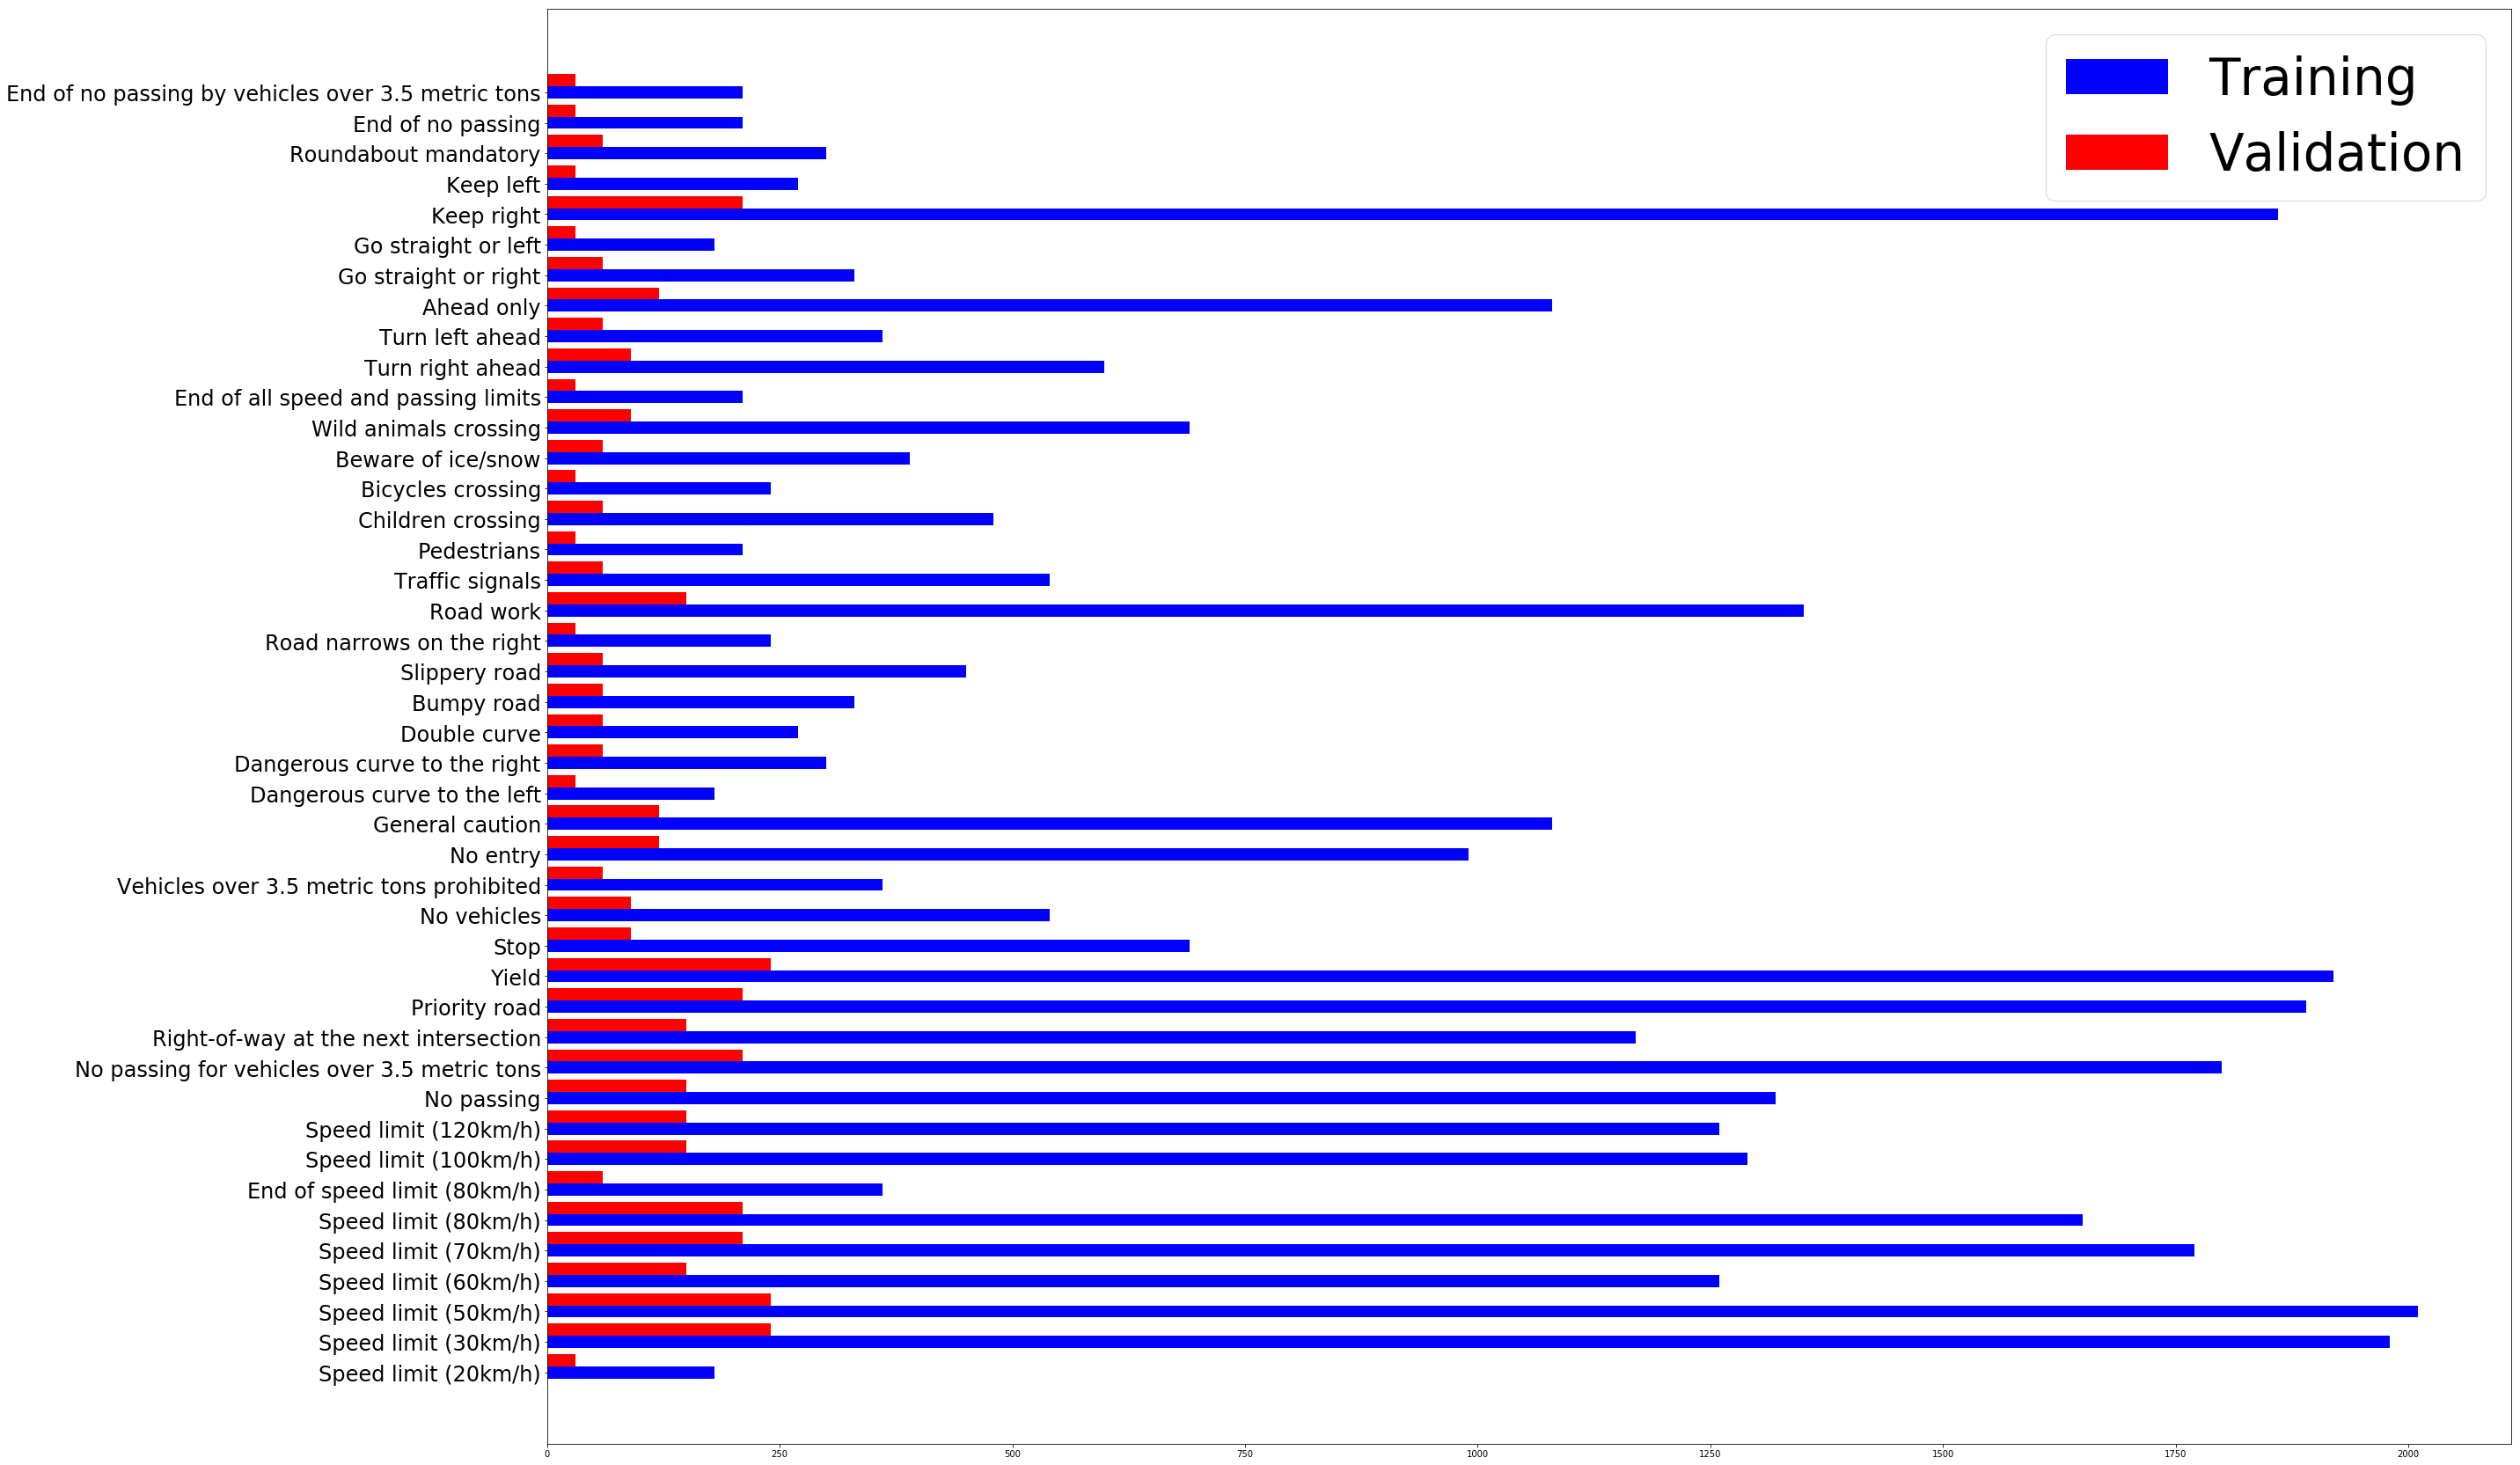

In [97]:
def summary(X_train, y_train, X_train_size, X_train_coord,X_validation, y_validation,X_test, y_test,df):
    n_train = X_train.shape[0]
    n_validation = X_validation.shape[0]
    n_test = X_test.shape[0]
    image_shape = X_train.shape[1:3]
    n_classes = max(max(y_train),max(y_train),max(y_test))+1 #there is a class 0
    
    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    count=Counter(y_train)
    count_validate=Counter(y_validation)
    print("Count of each sign in the training set:")
    print("{:5s} {:10s}  {:10s}\t {:25s}".format("Id","Training %","Validation %","Description"))
    value=[]
    value_validate=[]
    index=[]
    for key in sorted(count.keys()):    
        print (key,"\t","{:.2f}".format(count[key]*100/n_train),"\t  ","{:.2f}".format(count_validate[key]*100/n_validation),"\t",df['SignName'][int(key)])
        value.append(count[key])
        value_validate.append(count_validate[key])
        index.append(df['SignName'][int(key)])
    fig=plt.figure(figsize=(40,30))
    input_x = np.arange(len(index))
    width = 0.4       # the width of the bars
    ax = fig.add_subplot(111)
    rects1 = ax.barh(input_x, value, width, color='b')
    rects2 = ax.barh(input_x+width, value_validate, width, color='r')
    ax.set_yticks(input_x)
    ax.set_yticklabels(index,fontsize=24) 
    ax.legend((rects1[0], rects2[0]), ('Training', 'Validation'),fontsize=58 )
    plt.show()
    
    

def read_orig():
    training_file = "./traffic-signs-data/train.p"
    validation_file= "./traffic-signs-data/valid.p"
    testing_file = "./traffic-signs-data/test.p"
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        validation = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train, X_train_size, X_train_coord = train['features'], train['labels'],train['sizes'],train['coords']
    X_validation, y_validation = validation['features'], validation['labels']
    X_test, y_test = test['features'], test['labels']
    return X_train, y_train, X_train_size, X_train_coord,X_validation, y_validation,X_test, y_test 
X_train_orig, y_train_orig, X_train_size, X_train_coord,X_validation_orig, y_validation_orig,X_test_orig, y_test_orig =read_orig()
df=pd.read_csv('signnames.csv',header=0,index_col=0)
summary(X_train_orig, y_train_orig, X_train_size, X_train_coord,X_validation_orig, y_validation_orig,X_test_orig, y_test_orig ,df)

In [98]:
def do_aug(input_file,temp_path,output_file,num_of_classes,num_samples):
    '''
    Function to do data augmentation using the Augmentor library.It creates 
    a pickle file of the augmented data.Images exist on disk in the temp_path folder.
    They can be deleted if required
    do_aug(input_file,temp_path,output_file,num_of_classes,num_samples):
    '''
    temp_path="./"+temp_path
    output_file="./"+output_file
    i=0
    while i<num_of_classes:
        try:
            os.makedirs(temp_path+"/"+str(i))
        except:
            #delete folder and try creating again.
            shutil.rmtree(temp_path+"/"+str(i))
            print("Deleted existing folder",temp_path+"/"+str(i))
            i=i-1
        finally:
            i=i+1
    
    with open(input_file, mode='rb') as f:
        obj = pickle.load(f)
        X, y = obj['features'], obj['labels']
    for i in range(len(y)):
        plt.imshow(X[i])
        #Example aug_data/31/325.jpg (X[325] has label 31)
        plt.imsave(temp_path+"/"+str(y[i])+"/"+str(i)+".jpg", X[i])
    
    '''Augmentor requires a folder of images as input.'''
    for i in range(num_of_classes):
        # output folder of augmented data is the same as the input folder
        p=Augmentor.Pipeline(temp_path+"/"+str(i),".")
        p.rotate(probability=0.5,max_left_rotation=15,max_right_rotation=15)
        p.skew(0.5,0.5)
        #Adding 1000 augmented images
        val=p.sample(num_samples)

    obj={}
    #Remove existing output pickle if any
    try:
        os.remove(output_file)
    except:
        print("No existing file.Continuing")
    for i in range(num_of_classes):
        #there is always an extra folder named "/0" created .Removing that
        os.rmdir(temp_path+"/"+str(i)+"/0")
        X=np.array([])
        y=[]
        for filename in os.listdir(temp_path+"/"+str(i)):
            y.append(i)
            image = cv2.imread(temp_path+"/"+str(i)+"/"+filename)
            #since cv2.imread reads in BGR and we work with RGB 
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h,w,c=image.shape
            image=image.reshape(1,h,w,c)
            if len(X)==0:
                X=image
            else:
                X=np.concatenate((X, image),axis=0)
        
        #To delete the augmented data folder
        #shutil.rmtree(temp_path+"/"+str(i))
        
        #Write out pickled data for each class
        obj['features'] = X
        obj['labels'] = y
        #Open file in binary and append to it.
        with open(output_file,"ba+")as pfile:
            pickle.dump(obj,pfile,protocol=pickle.HIGHEST_PROTOCOL)
            print("dumped"+str(len(obj['features']))+" image's data")

def read_aug(file):
    '''
    Returns augmented data and label
    Input:Pickle file containing augmented data
    Output:X(4d np array),y(1d np array)
    '''
    X=[]
    y=[]
    with open(file, mode='rb') as f:
            for i in range(43):
                train = pickle.load(f)
                if len(X)==0:
                    X=train['features']
                    y=train['labels']
                else:
                    X=np.concatenate((X,train['features']))
                    y=np.concatenate((y,train['labels']))            
    return X,y

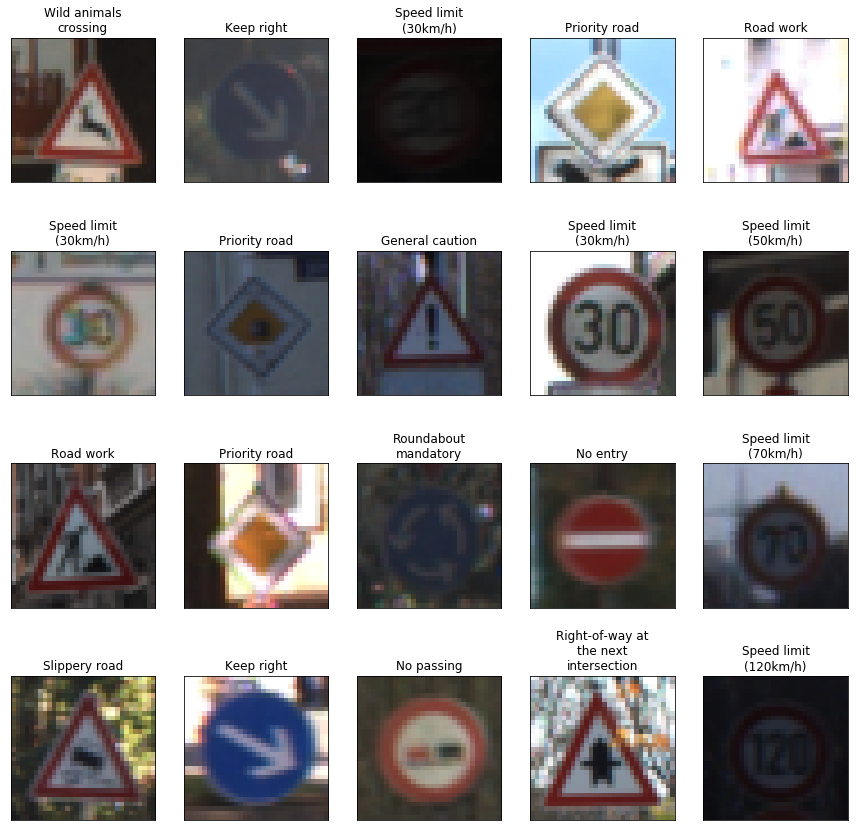

In [99]:
#Exploratory visualization of the dataset
plt.figure(figsize=(15,15))
for i in range(20):
    ax=plt.subplot(4,5,i+1)
    j=randint(0,len(X_train_orig))
    ax.set_title("\n".join(wrap(df['SignName'][int(y_train_orig[j])],15)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(X_train_orig[j])
plt.show()


In [100]:
# creates a new folder that contains the augmented images.It can be deleted if wanted by .Check do_aug()
#do_aug('traffic-signs-data/train.p','aug_data_train','traffic-signs-data/aug_train.p',43,1000)

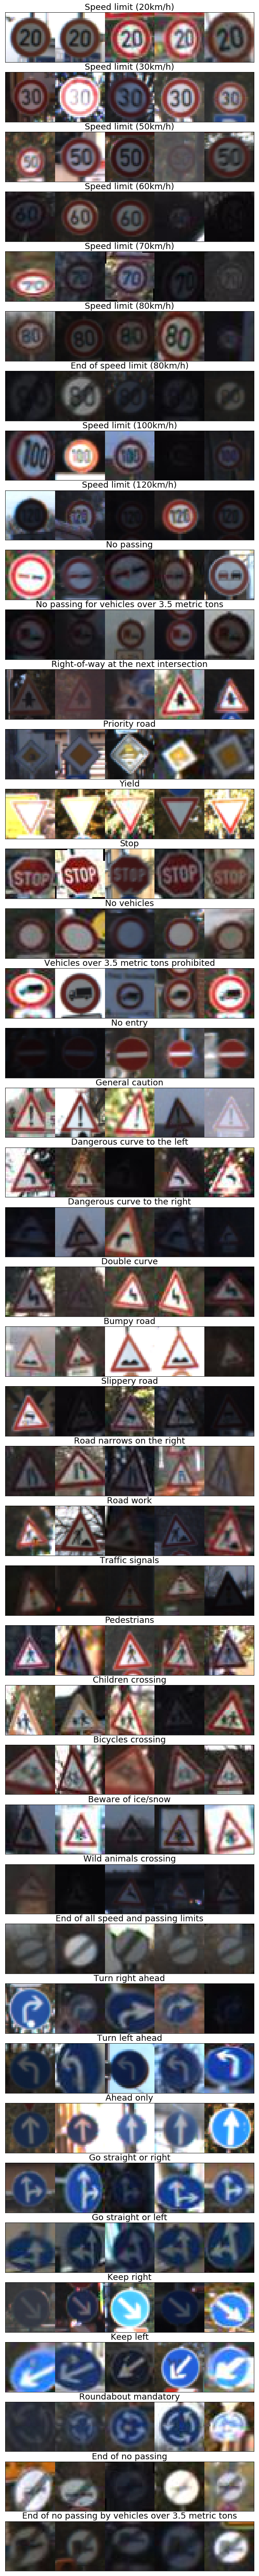

In [101]:
X_train_aug,y_train_aug=read_aug('traffic-signs-data/aug_train.p')
plt.clf()
#summary(X_train_aug, y_train_aug, X_train_size, X_train_coord,X_validation_orig, y_validation_orig,X_test_orig, y_test_orig,df)
plt.figure(figsize=(15,100))
for i in range(43):
    #print("\n".join(wrap(df['SignName'][int(i)],25)))
    files=os.listdir("aug_data_train"+"/"+str(i))
    index=sample(range(len(files)), 5)
    img=[]
    for file_index in index:
        image = cv2.imread("aug_data_train"+"/"+str(i)+"/"+files[file_index])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if len(img)==0:
            img=image
        else:
            img = np.append(img,image,axis=1)
    ax=plt.subplot(43,1,i+1)
    ax.set_title(df['SignName'][int(i)], fontsize=18)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img,cmap="gray")
plt.show()

In [102]:
def histogram_equalisation(X):
    # input X is 4d array so is the output
    temp_out=np.empty((len(X),default_h,default_w,X.shape[3]))
    out=np.empty((len(X),default_h,default_w,3))
    for i in range(len(X)):
        if (X.shape[1]!=32 or X.shape[2]!=32):
            temp_out[i]=cv2.resize(X[i],(32,32),interpolation=cv2.INTER_AREA).reshape(default_h,default_w,training_data_color)
            cv_img=temp_out[i].astype(np.uint8)
        else:
            temp_out[i]=X[i]
            cv_img=temp_out[i].astype(np.uint8)
        img_yuv=cv2.cvtColor(cv_img, cv2.COLOR_RGB2YCR_CB)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        out[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YCR_CB2RGB )
        temp_out[i]=out[i].astype(np.uint8)
        #ensure its the correct dimension
        temp_out[i].resize(1,default_h,default_w,3)
    temp_out=temp_out.astype(np.uint8)
    return temp_out

def normalize_gray(image):
        norm_image=np.copy(image)
        norm_image=cv2.normalize((cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)), dst=norm_image,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return norm_image
    
def pipeline(X,op):
    '''
    Always normalizes.Histogram equalization is optional
    Returns grayscale normalized image with an option for histogram equalisation
    '''
    if op=='hist':
        X=histogram_equalisation(X)
    train_image=np.array([normalize_gray(num) for num in X])
    n,h,w=train_image.shape
    X=train_image.reshape(n,h,w,1)
    return X 

In [103]:
X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()


preprocess_flag='hist'
X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

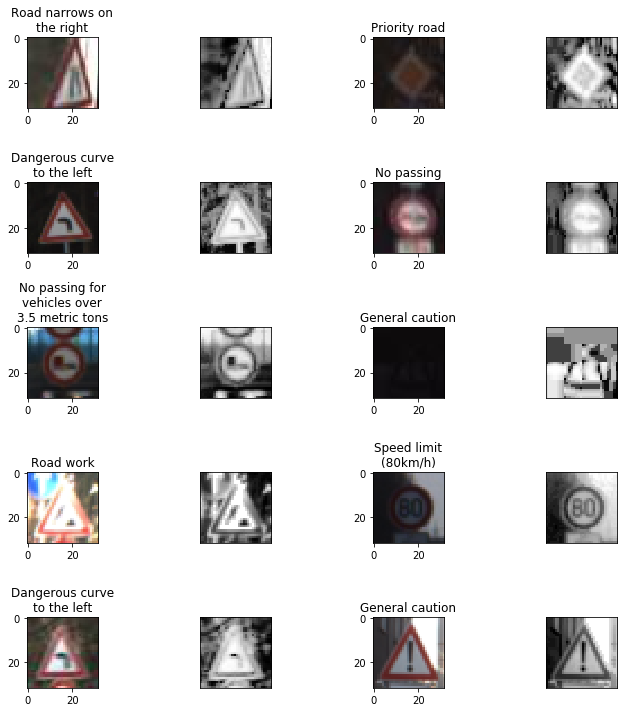

In [104]:
plt.figure(figsize=(10,10))
list=sample(range(len(X_train_aug)), 10)
num=1
for i in range(10):
    ax=plt.subplot(5,4,num)
    num=num+1
    j=list[i]
    ax.set_title("\n".join(wrap(df['SignName'][int(y_train_aug[j])],15)))
    ax.imshow(X_train_aug[j])
    ax=plt.subplot(5,4,num)
    plt.tight_layout()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(X_train[j].reshape(32,32),cmap='gray')
    num=num+1
plt.show()

In [105]:
def conv(input,filter_size,channel_in,channel_out,mu,sigma,stride,padding):
    weight = tf.Variable(tf.truncated_normal([filter_size, filter_size, channel_in, channel_out],mean=mu,stddev=sigma))
    bias = tf.Variable(tf.zeros(channel_out))
    conv_layer = tf.nn.conv2d(input, weight, strides=[1, stride, stride, 1], padding=padding)
    conv_layer = tf.nn.bias_add(conv_layer, bias)    
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

def fc(flat_layer,mu,sigma,input_size,output_size):
    weight=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias = tf.Variable(tf.zeros(output_size))
    fc=tf.matmul(flat_layer,weight)+bias
    fc_layer=tf.nn.relu(fc)
    return fc_layer

def cnn(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    global conv_layer1,conv_layer2,conv_layer3,conv_layer4
    
    c_in=[1,24,48]
    c_out=[24,48,96]
    nsize=32
    L=0
    ARGS=[(x,5,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer1=conv(*ARGS[0])
    conv_layer1=tf.nn.max_pool(conv_layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=16
    L=L+1
    ARGS=[(conv_layer1,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer2=conv(*ARGS[0])
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=8
    
    L=L+1
    ARGS=[(conv_layer2,2,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer3=conv(*ARGS[0])
    conv_layer3=tf.nn.max_pool(conv_layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=4
    prev_layer=conv_layer3
    
    # Flatten.
    flat_layer = tf.contrib.layers.flatten(prev_layer)
    
    # Layer: Fully Connected. 
    input_size=nsize*nsize*c_out[L]
    output_size=768
    fc_layer1=fc(flat_layer,mu,sigma,input_size,output_size)
    dropout1=tf.nn.dropout(fc_layer1,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=332
    fc_layer2=fc(dropout1,mu,sigma,input_size,output_size)
    dropout2=tf.nn.dropout(fc_layer2,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=43
    
    weight5=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.zeros(output_size))
    logits=tf.matmul(fc_layer2,weight5)+bias5    
    return logits

In [106]:
def LeNet5(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    global conv_layer1,conv_layer2,conv_layer3,conv_layer4
    
    c_in=[1,6]
    c_out=[6,16]
    nsize=32
    L=0
    ARGS=[(x,5,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer1=conv(*ARGS[0])
    conv_layer1=tf.nn.max_pool(conv_layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=16
    L=L+1
    ARGS=[(conv_layer1,5,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer2=conv(*ARGS[0])
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=8
    prev_layer=conv_layer2
    
    # Flatten.
    flat_layer = tf.contrib.layers.flatten(prev_layer)
    
    # Layer: Fully Connected. 
    input_size=nsize*nsize*c_out[L]
    output_size=120
    fc_layer1=fc(flat_layer,mu,sigma,input_size,output_size)
    dropout1=tf.nn.dropout(fc_layer1,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=84
    fc_layer2=fc(dropout1,mu,sigma,input_size,output_size)
    dropout2=tf.nn.dropout(fc_layer2,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=43
    
    weight5=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.zeros(output_size))
    logits=tf.matmul(fc_layer2,weight5)+bias5    
    return logits

In [107]:
def cnn_mod(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    global conv_layer1,conv_layer2,conv_layer3,conv_layer4
    
    c_in=[1,24,48]
    c_out=[24,48,96]
    nsize=32
    L=0
    ARGS=[(x,5,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer1=conv(*ARGS[0])
    conv_layer1=tf.nn.max_pool(conv_layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=16
    L=L+1
    ARGS=[(conv_layer1,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer2=conv(*ARGS[0])
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=8
    
    L=L+1
    ARGS=[(conv_layer2,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer3=conv(*ARGS[0])
    conv_layer3=tf.nn.max_pool(conv_layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=4
    prev_layer=conv_layer3
    
    # Flatten.
    flat_layer = tf.contrib.layers.flatten(prev_layer)
    
    # Layer: Fully Connected. 
    input_size=nsize*nsize*c_out[L]
    output_size=768
    fc_layer1=fc(flat_layer,mu,sigma,input_size,output_size)
    dropout1=tf.nn.dropout(fc_layer1,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=332
    fc_layer2=fc(dropout1,mu,sigma,input_size,output_size)
    dropout2=tf.nn.dropout(fc_layer2,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=43
    
    weight5=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.zeros(output_size))
    logits=tf.matmul(fc_layer2,weight5)+bias5    
    return logits

In [108]:
def cnn_mod2(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    global conv_layer1,conv_layer2,conv_layer3,conv_layer4
    
    c_in=[1,24,48]
    c_out=[24,48,96]
    nsize=32
    L=0
    ARGS=[(x,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer1=conv(*ARGS[0])
    conv_layer1=tf.nn.max_pool(conv_layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=16
    L=L+1
    ARGS=[(conv_layer1,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer2=conv(*ARGS[0])
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=8
    
    L=L+1
    ARGS=[(conv_layer2,3,c_in[L],c_out[L],mu,sigma,1,'SAME')]
    conv_layer3=conv(*ARGS[0])
    conv_layer3=tf.nn.max_pool(conv_layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    nsize=4
    prev_layer=conv_layer3
    
    # Flatten.
    flat_layer = tf.contrib.layers.flatten(prev_layer)
    
    # Layer: Fully Connected. 
    input_size=nsize*nsize*c_out[L]
    output_size=768
    fc_layer1=fc(flat_layer,mu,sigma,input_size,output_size)
    dropout1=tf.nn.dropout(fc_layer1,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=332
    fc_layer2=fc(dropout1,mu,sigma,input_size,output_size)
    dropout2=tf.nn.dropout(fc_layer2,keep_prob)
    # Layer: Fully Connected.
    input_size=output_size
    output_size=43
    
    weight5=tf.Variable(tf.truncated_normal([input_size,output_size],mean=mu,stddev=sigma))
    bias5 = tf.Variable(tf.zeros(output_size))
    logits=tf.matmul(fc_layer2,weight5)+bias5    
    return logits

In [109]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def softmax(X_data):
    values,indices=sess.run(tf.nn.top_k(logits, k=5),feed_dict={x:X_data,keep_prob: 1})
    return values,indices

def train(function,dropout_rate,EPOCHS,file= './lenet'):
    
    global accuracy_operation,correct_prediction,training_operation,optimizer,loss_operation
    global cross_entropy,logits,x,y,one_hot_y,rate,keep_prob
    global X_train,X_test,X_validation,y_train,y_test,y_validation
    global saver
    global sess
    global BATCH_SIZE
    
    X_train, y_train = shuffle(X_train, y_train)
    X_validation,y_validation=shuffle(X_validation,y_validation)
    X_test,y_test=shuffle(X_test,y_test)
    
    x = tf.placeholder(tf.float32, (None, 32, 32, 1),name="x_for_training")
    y = tf.placeholder(tf.int32, (None),name="y_for_Training")
    keep_prob=tf.placeholder(tf.float32,(None),name="dropout_percent")
    one_hot_y = tf.one_hot(y, 43)
    rate = 0.001
    
    logits = function(x,keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    ########
    #graph inputs
    v_error=[]
    t_error=[]
    x_axis=[]
    train_accuracy=0
    validation_accuracy=0
    ########
    print("{:10s}{:15s}{:15s}".format("EPOCH" ,"Train Accuracy","Validation Accuracy" ))
    for i in range(EPOCHS):
        train_accuracy=0
        count=0
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:dropout_rate})   
            train_accuracy=train_accuracy+evaluate(batch_x, batch_y)
            count=count+1
        train_accuracy=train_accuracy/count
        t_error=t_error+[1-train_accuracy]
        
        x_axis=x_axis+[i]
        
        validation_accuracy = evaluate(X_validation, y_validation)
        v_error=v_error+[1-validation_accuracy]
        print(" {:10s} {:15.3f}{:15.3f}".format(str(i+1),train_accuracy,validation_accuracy))    

    saver.save(sess, file)
    print("Model saved")
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy  = evaluate(X_test, y_test)
    train_accuracy = evaluate(X_train, y_train)
    validation_accuracy = evaluate(X_validation, y_validation)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    plt.figure(figsize=(5,5))
    plt.xticks(x_axis)
    plt.ylim(ymax=1,ymin=0)
    plt.plot(x_axis, v_error, '-ro',label='validation error')
    plt.plot(x_axis, t_error, '-bo',label='training error')
    plt.legend(loc='upper center', shadow=True)
    plt.show()

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    vis=[]
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    for featuremap in range(featuremaps):
        img=activation[0,:,:, featuremap]
        img=cv2.resize(img,(20,20))
        if len(vis):
            vis = np.concatenate((vis, img),axis=1)
        else:
            vis=img
    return vis

def myexamples(preprocess_flag):
    global saver
    global sess
    arr=[]
    X_myex=[]
    y_ex=[]
    num=1
    plt.figure(figsize=(15,15))
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    for filename in os.listdir("myexamples/"):
        arr=[]
        image = cv2.imread('myexamples/'+filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image= cv2.resize(image,(32,32))
        plt.figure(figsize=(15,15))
        plt.subplot(10,2,num)
        plt.imshow(image,interpolation="nearest", cmap="gray")
        
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        h,w,c=image.shape
        image.resize(1,h,w,c)
        out=pipeline(image,preprocess_flag)
        arr.append(out[0])
        X_myex.append(arr[0])
        arr=np.array(arr)
        values,indices =softmax(arr)
        e_x = np.exp(values - np.max(values))
        soft_out = e_x / e_x.sum()
        index=[]
        global df
        index=[df['SignName'][int(key)] for key in tuple(indices.tolist()[0])]
        plt.subplot(10,2,num+1)
        plt.xlim(0,1)
        input_x = np.arange(len(index))
        plt.yticks(input_x, index)
        plt.barh(input_x,soft_out.tolist()[0])    
    #for usage by showfeature
    X_myex=np.array(X_myex)
    return X_myex

def showfeature(X_myex_input,X_layer):
    plt.figure(figsize=(40,40))   
    num=len(os.listdir("myexamples/"))
    global conv_layer1
    count=0
    for i in range(num):
        plt.subplot(num,1,i+1)
        out=outputFeatureMap(X_myex_input[i:i+1],X_layer)
        for offset in range(0, out.shape[1], 480):
            end = offset + 480
            count=count+1
            if offset==0:
                image=out[:,offset:end]
            else:
                image=np.concatenate(( image,out[:,offset:end]),axis=0)
        plt.tight_layout()
        plt.get_xaxis().set_visible(False)
        plt.get_yaxis().set_visible(False)
        plt.imshow(image,interpolation="nearest",cmap='gray')  
    plt.show() 

In [110]:
'''
Things to try 
1)Data augmentation -Yes or No
2)Preprocessing - Yes or No
3)Architecture - LeNet-5 or my CNN
4)Hyperparameters
    - Dropout % - 0.2,0.4,0.6
'''

'\nThings to try \n1)Data augmentation -Yes or No\n2)Preprocessing - Yes or No\n3)Architecture - LeNet-5 or my CNN\n4)Hyperparameters\n    - Dropout % - 0.2,0.4,0.6\n'

In [15]:
'''
NO Augmentation
NO preprocessing
CNN
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nCNN\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.742          0.821
 2                    0.974          0.863
 3                    0.994          0.883
 4                    0.998          0.910
 5                    0.999          0.905
 6                    1.000          0.920
 7                    1.000          0.920
 8                    1.000          0.920
 9                    0.999          0.924
 10                   1.000          0.925
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.925
Test Accuracy = 0.917


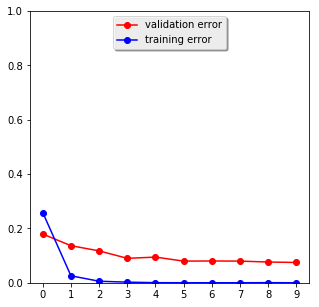

<IPython.core.display.Javascript object>

In [16]:
%%notify -m "1 done"
X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [17]:
'''
NO Augmentation
NO preprocessing
LeNet5
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.556          0.747
 2                    0.899          0.829
 3                    0.950          0.868
 4                    0.971          0.868
 5                    0.981          0.875
 6                    0.987          0.880
 7                    0.993          0.885
 8                    0.995          0.871
 9                    0.996          0.898
 10                   0.996          0.878
Model saved
Train Accuracy = 0.991
Validation Accuracy = 0.878
Test Accuracy = 0.869


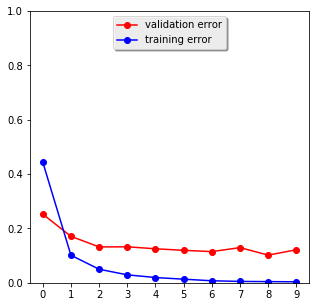

<IPython.core.display.Javascript object>

In [18]:
%%notify -m "2 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [19]:
'''
YES Augmentation
NO preprocessing
LeNet5
Dropout=1.0
'''

'\nYES Augmentation\nNO preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.582          0.747
 2                    0.842          0.802
 3                    0.898          0.828
 4                    0.926          0.834
 5                    0.945          0.839
 6                    0.957          0.839
 7                    0.966          0.846
 8                    0.973          0.852
 9                    0.978          0.850
 10                   0.983          0.850
Model saved
Train Accuracy = 0.968
Validation Accuracy = 0.850
Test Accuracy = 0.859


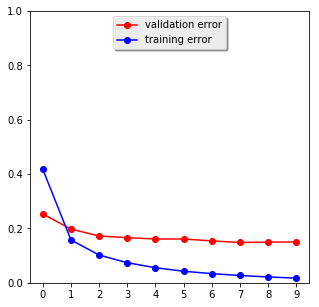

<IPython.core.display.Javascript object>

In [20]:
%%notify -m "3 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [21]:
'''
YES Augmentation
NO preprocessing
cnn
Dropout=1.0
'''

'\nYES Augmentation\nNO preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.599          0.764
 2                    0.850          0.810
 3                    0.902          0.822
 4                    0.929          0.825
 5                    0.948          0.827
 6                    0.961          0.832
 7                    0.969          0.840
 8                    0.975          0.853
 9                    0.980          0.862
 10                   0.985          0.854
Model saved
Train Accuracy = 0.972
Validation Accuracy = 0.854
Test Accuracy = 0.867


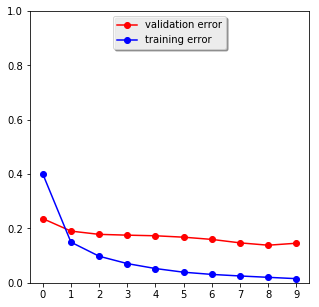

<IPython.core.display.Javascript object>

In [22]:
%%notify -m "4 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [23]:
'''
NO Augmentation
YES preprocessing
LeNet5
Dropout=1.0
'''

'\nNO Augmentation\nYES preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.483          0.684
 2                    0.846          0.819
 3                    0.919          0.842
 4                    0.949          0.860
 5                    0.964          0.876
 6                    0.973          0.888
 7                    0.982          0.892
 8                    0.988          0.891
 9                    0.992          0.888
 10                   0.993          0.899
Model saved
Train Accuracy = 0.983
Validation Accuracy = 0.899
Test Accuracy = 0.871


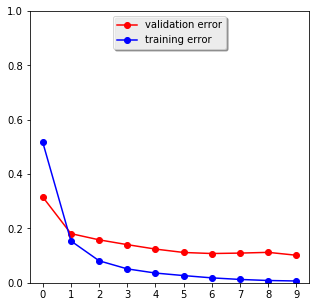

<IPython.core.display.Javascript object>

In [31]:
%%notify -m "5 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [25]:
'''
NO Augmentation
YES preprocessing
cnn
Dropout=1.0
'''

'\nNO Augmentation\nYES preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.679          0.812
 2                    0.962          0.869
 3                    0.989          0.899
 4                    0.996          0.898
 5                    0.998          0.898
 6                    0.999          0.902
 7                    1.000          0.909
 8                    1.000          0.920
 9                    0.999          0.884
 10                   0.999          0.920
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.920
Test Accuracy = 0.913


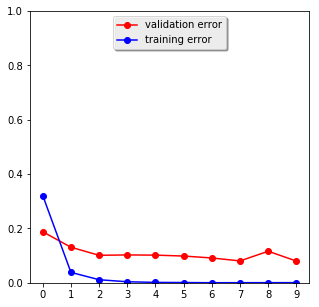

<IPython.core.display.Javascript object>

In [26]:
%%notify -m "6 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [27]:
'''
YES Augmentation
YES preprocessing
LeNet5
Dropout=1.0
'''

'\nYES Augmentation\nYES preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.502          0.701
 2                    0.785          0.796
 3                    0.857          0.838
 4                    0.891          0.872
 5                    0.914          0.892
 6                    0.930          0.887
 7                    0.941          0.895
 8                    0.951          0.892
 9                    0.960          0.886
 10                   0.966          0.879
Model saved
Train Accuracy = 0.952
Validation Accuracy = 0.879
Test Accuracy = 0.871


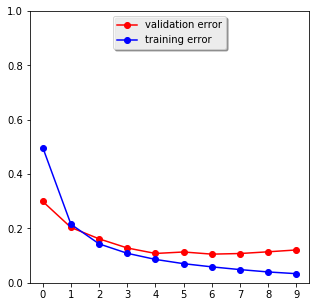

<IPython.core.display.Javascript object>

In [28]:
%%notify -m "7 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [29]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=1.0
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.742          0.878
 2                    0.952          0.907
 3                    0.983          0.908
 4                    0.993          0.927
 5                    0.997          0.928
 6                    0.999          0.921
 7                    0.999          0.938
 8                    0.999          0.926
 9                    1.000          0.946
 10                   0.999          0.935
Model saved
Train Accuracy = 0.992
Validation Accuracy = 0.935
Test Accuracy = 0.905


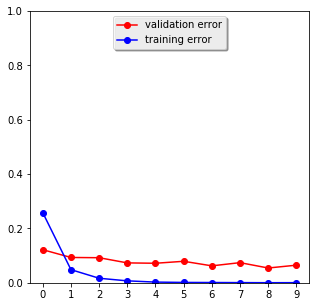

<IPython.core.display.Javascript object>

In [30]:
%%notify -m "8 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [32]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.8
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.8\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.690          0.858
 2                    0.940          0.916
 3                    0.978          0.909
 4                    0.990          0.920
 5                    0.996          0.913
 6                    0.997          0.923
 7                    0.998          0.942
 8                    0.998          0.926
 9                    0.999          0.944
 10                   0.999          0.942
Model saved
Train Accuracy = 0.996
Validation Accuracy = 0.942
Test Accuracy = 0.923


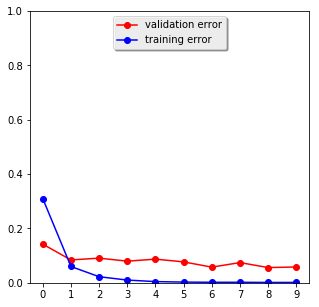

<IPython.core.display.Javascript object>

In [33]:
%%notify -m "9 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.8,EPOCHS=10)

In [34]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.4
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.639          0.888
 2                    0.932          0.947
 3                    0.969          0.958
 4                    0.983          0.966
 5                    0.989          0.966
 6                    0.993          0.968
 7                    0.995          0.967
 8                    0.996          0.969
 9                    0.997          0.968
 10                   0.997          0.968
Model saved
Train Accuracy = 0.997
Validation Accuracy = 0.968
Test Accuracy = 0.946


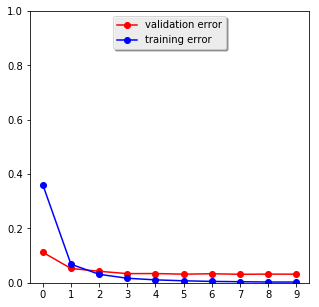

<IPython.core.display.Javascript object>

In [35]:
%%notify -m "10 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.4,EPOCHS=10)

In [36]:
'''
NO Augmentation
NO preprocessing
CNN
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nCNN\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.724          0.845
 2                    0.976          0.907
 3                    0.995          0.908
 4                    0.998          0.930
 5                    0.999          0.927
 6                    0.999          0.928
 7                    0.999          0.946
 8                    1.000          0.944
 9                    1.000          0.941
 10                   1.000          0.931
Model saved
Train Accuracy = 0.996
Validation Accuracy = 0.931
Test Accuracy = 0.922


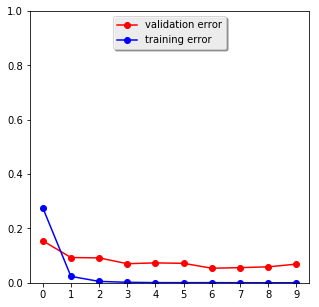

<IPython.core.display.Javascript object>

In [37]:
%%notify -m "11 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.8,EPOCHS=10)

In [38]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.6
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.6\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.704          0.888
 2                    0.947          0.929
 3                    0.977          0.939
 4                    0.988          0.955
 5                    0.993          0.960
 6                    0.996          0.958
 7                    0.997          0.962
 8                    0.998          0.956
 9                    0.998          0.967
 10                   0.999          0.966
Model saved
Train Accuracy = 0.997
Validation Accuracy = 0.966
Test Accuracy = 0.939


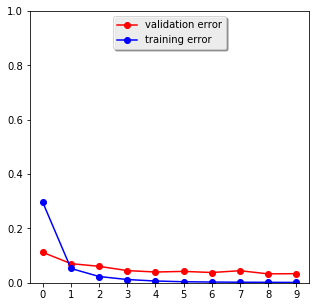

<IPython.core.display.Javascript object>

In [39]:
%%notify -m "12 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.6,EPOCHS=10)

In [40]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.501          0.787
 2                    0.871          0.889
 3                    0.933          0.928
 4                    0.957          0.950
 5                    0.970          0.964
 6                    0.978          0.968
 7                    0.983          0.970
 8                    0.988          0.969
 9                    0.989          0.972
 10                   0.991          0.977
Model saved
Train Accuracy = 0.989
Validation Accuracy = 0.977
Test Accuracy = 0.947


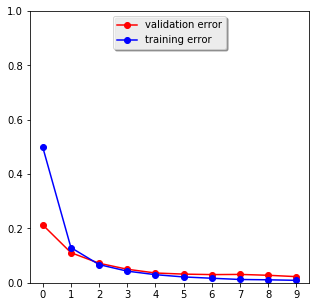

<IPython.core.display.Javascript object>

In [41]:
%%notify -m "13 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.2,EPOCHS=10)

In [42]:
'''
NO Augmentation
NO preprocessing
CNN
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nCNN\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.742          0.829
 2                    0.978          0.879
 3                    0.995          0.894
 4                    0.998          0.899
 5                    1.000          0.914
 6                    0.999          0.894
 7                    1.000          0.901
 8                    1.000          0.937
 9                    0.999          0.912
 10                   1.000          0.934
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.934
Test Accuracy = 0.913


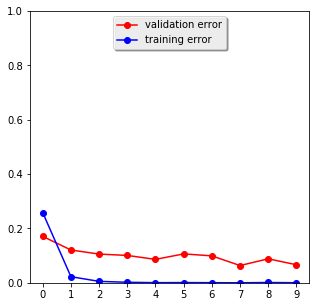

<IPython.core.display.Javascript object>

In [43]:
%%notify -m "1 done"
X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [44]:
'''
NO Augmentation
NO preprocessing
LeNet5
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.556          0.740
 2                    0.897          0.822
 3                    0.946          0.860
 4                    0.967          0.871
 5                    0.981          0.882
 6                    0.987          0.882
 7                    0.992          0.880
 8                    0.993          0.881
 9                    0.996          0.884
 10                   0.997          0.887
Model saved
Train Accuracy = 0.989
Validation Accuracy = 0.887
Test Accuracy = 0.866


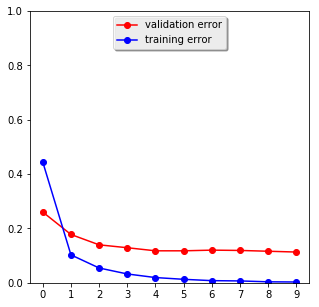

<IPython.core.display.Javascript object>

In [45]:
%%notify -m "2 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [46]:
'''
YES Augmentation
NO preprocessing
LeNet5
Dropout=1.0
'''

'\nYES Augmentation\nNO preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.594          0.763
 2                    0.848          0.817
 3                    0.904          0.830
 4                    0.931          0.850
 5                    0.949          0.853
 6                    0.963          0.850
 7                    0.971          0.859
 8                    0.978          0.863
 9                    0.984          0.855
 10                   0.987          0.857
Model saved
Train Accuracy = 0.972
Validation Accuracy = 0.857
Test Accuracy = 0.870


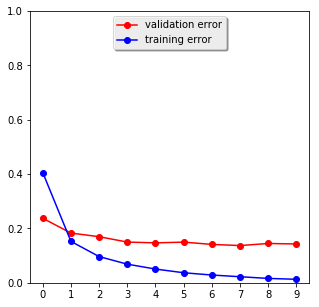

<IPython.core.display.Javascript object>

In [47]:
%%notify -m "3 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [48]:
'''
YES Augmentation
NO preprocessing
cnn
Dropout=1.0
'''

'\nYES Augmentation\nNO preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.587          0.785
 2                    0.847          0.815
 3                    0.902          0.836
 4                    0.932          0.849
 5                    0.950          0.858
 6                    0.963          0.868
 7                    0.973          0.867
 8                    0.979          0.865
 9                    0.984          0.866
 10                   0.987          0.866
Model saved
Train Accuracy = 0.972
Validation Accuracy = 0.866
Test Accuracy = 0.864


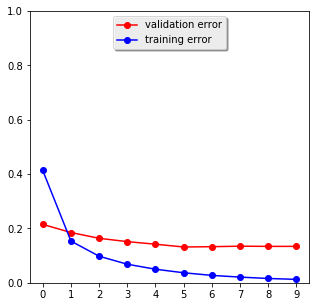

<IPython.core.display.Javascript object>

In [49]:
%%notify -m "4 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [50]:
'''
NO Augmentation
YES preprocessing
LeNet5
Dropout=1.0
'''

'\nNO Augmentation\nYES preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.493          0.688
 2                    0.849          0.795
 3                    0.916          0.838
 4                    0.945          0.855
 5                    0.958          0.867
 6                    0.969          0.875
 7                    0.977          0.881
 8                    0.983          0.879
 9                    0.988          0.878
 10                   0.991          0.886
Model saved
Train Accuracy = 0.988
Validation Accuracy = 0.886
Test Accuracy = 0.880


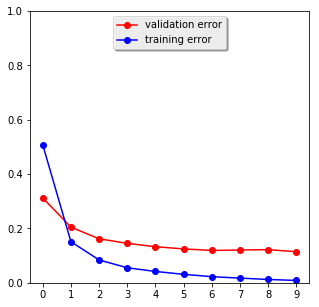

<IPython.core.display.Javascript object>

In [51]:
%%notify -m "5 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [52]:
'''
NO Augmentation
YES preprocessing
cnn
Dropout=1.0
'''

'\nNO Augmentation\nYES preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.671          0.815
 2                    0.964          0.874
 3                    0.989          0.887
 4                    0.996          0.907
 5                    0.999          0.914
 6                    0.999          0.905
 7                    1.000          0.914
 8                    1.000          0.902
 9                    1.000          0.921
 10                   1.000          0.910
Model saved
Train Accuracy = 0.997
Validation Accuracy = 0.910
Test Accuracy = 0.893


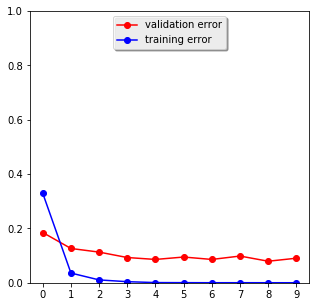

<IPython.core.display.Javascript object>

In [53]:
%%notify -m "6 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [54]:
'''
YES Augmentation
YES preprocessing
LeNet5
Dropout=1.0
'''

'\nYES Augmentation\nYES preprocessing\nLeNet5\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.522          0.722
 2                    0.802          0.806
 3                    0.866          0.828
 4                    0.899          0.846
 5                    0.921          0.858
 6                    0.936          0.861
 7                    0.947          0.860
 8                    0.957          0.860
 9                    0.964          0.866
 10                   0.970          0.862
Model saved
Train Accuracy = 0.957
Validation Accuracy = 0.862
Test Accuracy = 0.850


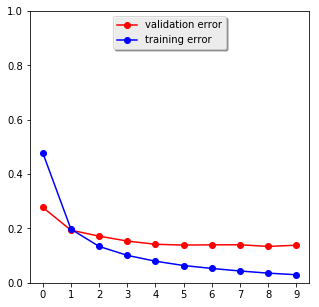

<IPython.core.display.Javascript object>

In [55]:
%%notify -m "7 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=LeNet5,dropout_rate=1.0,EPOCHS=10)

In [56]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=1.0
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.735          0.853
 2                    0.952          0.909
 3                    0.983          0.909
 4                    0.993          0.936
 5                    0.997          0.937
 6                    0.999          0.937
 7                    0.999          0.920
 8                    0.999          0.931
 9                    0.999          0.927
 10                   1.000          0.935
Model saved
Train Accuracy = 0.994
Validation Accuracy = 0.935
Test Accuracy = 0.915


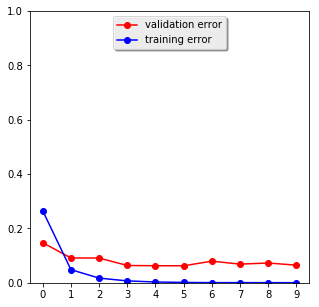

<IPython.core.display.Javascript object>

In [57]:
%%notify -m "8 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=1.0,EPOCHS=10)

In [58]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.8
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.8\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.696          0.874
 2                    0.945          0.924
 3                    0.979          0.936
 4                    0.990          0.937
 5                    0.995          0.926
 6                    0.997          0.937
 7                    0.998          0.951
 8                    0.998          0.948
 9                    0.999          0.956
 10                   0.999          0.951
Model saved
Train Accuracy = 0.997
Validation Accuracy = 0.951
Test Accuracy = 0.925


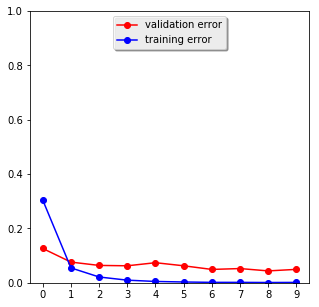

<IPython.core.display.Javascript object>

In [59]:
%%notify -m "9 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.8,EPOCHS=10)

In [60]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.4
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.620          0.866
 2                    0.926          0.934
 3                    0.966          0.957
 4                    0.981          0.956
 5                    0.989          0.959
 6                    0.992          0.970
 7                    0.995          0.962
 8                    0.996          0.963
 9                    0.997          0.964
 10                   0.997          0.959
Model saved
Train Accuracy = 0.995
Validation Accuracy = 0.959
Test Accuracy = 0.943


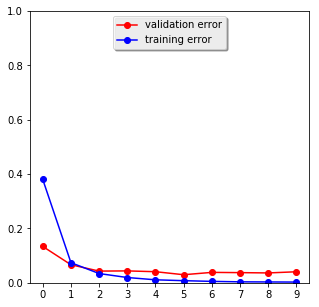

<IPython.core.display.Javascript object>

In [61]:
%%notify -m "10 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.4,EPOCHS=10)

In [62]:
'''
NO Augmentation
NO preprocessing
CNN
Dropout=1.0
'''

'\nNO Augmentation\nNO preprocessing\nCNN\nDropout=1.0\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.718          0.805
 2                    0.977          0.870
 3                    0.994          0.918
 4                    0.997          0.927
 5                    0.999          0.919
 6                    0.999          0.934
 7                    1.000          0.928
 8                    1.000          0.929
 9                    0.999          0.949
 10                   1.000          0.932
Model saved
Train Accuracy = 0.999
Validation Accuracy = 0.932
Test Accuracy = 0.923


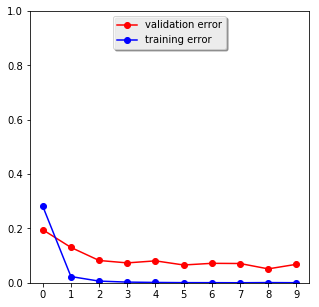

<IPython.core.display.Javascript object>

In [63]:
%%notify -m "11 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='none'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.8,EPOCHS=10)

In [64]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.6
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.6\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.694          0.882
 2                    0.942          0.941
 3                    0.976          0.953
 4                    0.988          0.949
 5                    0.993          0.960
 6                    0.996          0.957
 7                    0.997          0.956
 8                    0.998          0.957
 9                    0.998          0.950
 10                   0.998          0.956
Model saved
Train Accuracy = 0.994
Validation Accuracy = 0.956
Test Accuracy = 0.928


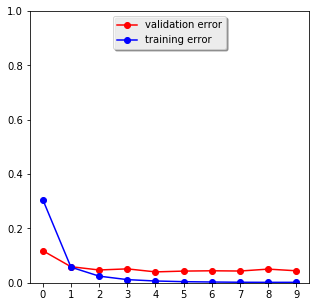

<IPython.core.display.Javascript object>

In [65]:
%%notify -m "12 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.6,EPOCHS=10)

In [66]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.553          0.840
 2                    0.899          0.942
 3                    0.951          0.970
 4                    0.971          0.980
 5                    0.980          0.981
 6                    0.985          0.983
 7                    0.989          0.984
 8                    0.992          0.984
 9                    0.993          0.976
 10                   0.994          0.981
Model saved
Train Accuracy = 0.993
Validation Accuracy = 0.981
Test Accuracy = 0.955


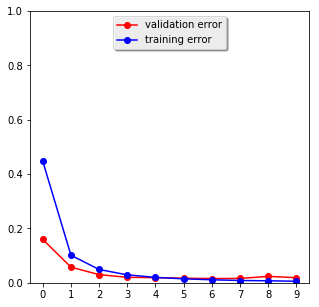

<IPython.core.display.Javascript object>

In [67]:
%%notify -m "13 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.2,EPOCHS=10)

In [68]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.1
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.1\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.310          0.625
 2                    0.728          0.857
 3                    0.879          0.929
 4                    0.928          0.960
 5                    0.949          0.961
 6                    0.962          0.967
 7                    0.969          0.973
 8                    0.974          0.976
 9                    0.978          0.966
 10                   0.982          0.976
Model saved
Train Accuracy = 0.985
Validation Accuracy = 0.976
Test Accuracy = 0.958


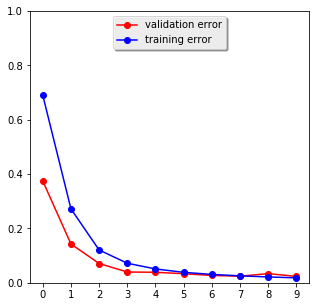

<IPython.core.display.Javascript object>

In [69]:
%%notify -m "14 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.1,EPOCHS=10)

In [70]:
'''
YES Augmentation
YES preprocessing
cnn
Dropout=0.1
'''

'\nYES Augmentation\nYES preprocessing\ncnn\nDropout=0.1\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.332          0.626
 2                    0.761          0.866
 3                    0.890          0.933
 4                    0.932          0.962
 5                    0.952          0.967
 6                    0.963          0.969
 7                    0.969          0.976
 8                    0.975          0.970
 9                    0.978          0.971
 10                   0.982          0.975
Model saved
Train Accuracy = 0.978
Validation Accuracy = 0.975
Test Accuracy = 0.951


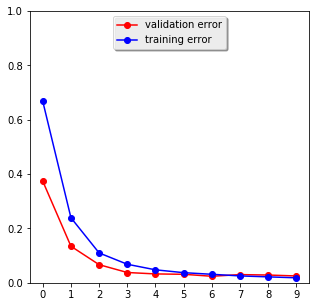

<IPython.core.display.Javascript object>

In [71]:
%%notify -m "14 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.1,EPOCHS=10)

In [73]:
'''
YES Augmentation
YES preprocessing
cnn_mod
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.495          0.795
 2                    0.871          0.901
 3                    0.940          0.939
 4                    0.964          0.960
 5                    0.976          0.959
 6                    0.983          0.973
 7                    0.987          0.976
 8                    0.990          0.965
 9                    0.992          0.976
 10                   0.994          0.984
Model saved
Train Accuracy = 0.996
Validation Accuracy = 0.984
Test Accuracy = 0.961


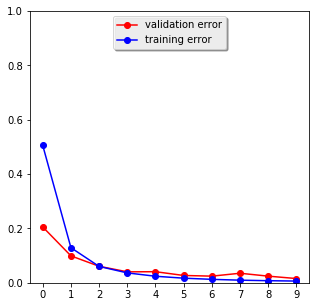

<IPython.core.display.Javascript object>

In [74]:
%%notify -m "15 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.2,EPOCHS=10)

In [75]:
'''
YES Augmentation
YES preprocessing
cnn_mod
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.642          0.858
 2                    0.931          0.929
 3                    0.970          0.954
 4                    0.983          0.957
 5                    0.990          0.965
 6                    0.993          0.963
 7                    0.995          0.965
 8                    0.996          0.972
 9                    0.997          0.970
 10                   0.998          0.969
Model saved
Train Accuracy = 0.995
Validation Accuracy = 0.969
Test Accuracy = 0.947


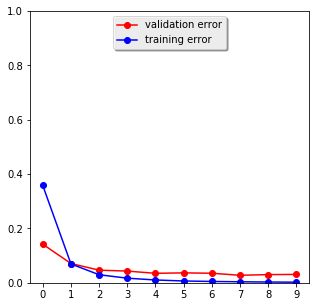

<IPython.core.display.Javascript object>

In [76]:
%%notify -m "16 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.4,EPOCHS=10)

In [78]:
'''
YES Augmentation
YES preprocessing
cnn_mod
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.510          0.816
 2                    0.877          0.928
 3                    0.939          0.955
 4                    0.963          0.969
 5                    0.975          0.971
 6                    0.982          0.980
 7                    0.987          0.979
 8                    0.991          0.976
 9                    0.992          0.972
 10                   0.994          0.968
Model saved
Train Accuracy = 0.987
Validation Accuracy = 0.968
Test Accuracy = 0.946


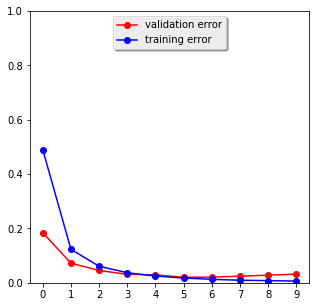

<IPython.core.display.Javascript object>

In [79]:
%%notify -m "15 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.2,EPOCHS=10)

In [80]:
'''
YES Augmentation
YES preprocessing
cnn_mod
Dropout=0.4
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.614          0.829
 2                    0.918          0.925
 3                    0.964          0.929
 4                    0.980          0.952
 5                    0.988          0.953
 6                    0.992          0.959
 7                    0.995          0.959
 8                    0.996          0.954
 9                    0.997          0.954
 10                   0.997          0.959
Model saved
Train Accuracy = 0.997
Validation Accuracy = 0.959
Test Accuracy = 0.935


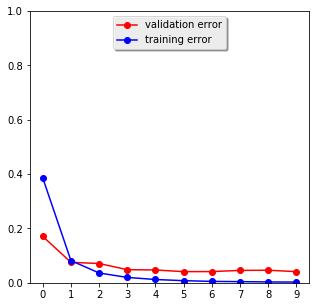

<IPython.core.display.Javascript object>

In [81]:
%%notify -m "16 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.4,EPOCHS=10)

In [87]:
'''
NO Augmentation
NO preprocessing
cnn_mod
Dropout=0.4
'''

'\nNO Augmentation\nNO preprocessing\ncnn_mod\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.528          0.760
 2                    0.904          0.851
 3                    0.967          0.907
 4                    0.982          0.925
 5                    0.992          0.940
 6                    0.995          0.932
 7                    0.997          0.938
 8                    0.998          0.935
 9                    0.999          0.935
 10                   0.999          0.940
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.940
Test Accuracy = 0.919


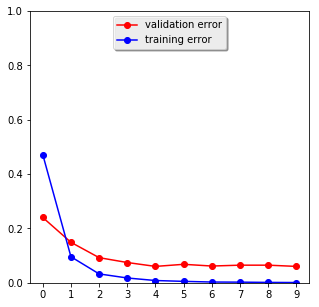

<IPython.core.display.Javascript object>

In [113]:
%%notify -m "17 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.4,EPOCHS=10)

In [114]:
'''
NO Augmentation
NO preprocessing
cnn_mod
Dropout=0.4
'''

'\nNO Augmentation\nNO preprocessing\ncnn_mod\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.534          0.704
 2                    0.909          0.853
 3                    0.968          0.903
 4                    0.985          0.925
 5                    0.993          0.935
 6                    0.996          0.934
 7                    0.997          0.940
 8                    0.997          0.927
 9                    0.999          0.940
 10                   0.999          0.948
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.948
Test Accuracy = 0.932


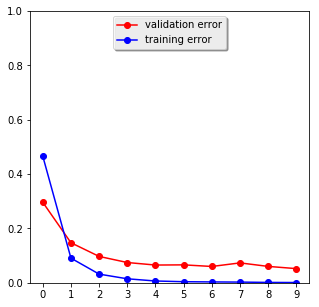

<IPython.core.display.Javascript object>

In [115]:
%%notify -m "17 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.4,EPOCHS=10)

In [91]:
'''
YES Augmentation
YES preprocessing
cnn_mod2
Dropout=0.4
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod2\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.642          0.854
 2                    0.925          0.940
 3                    0.965          0.956
 4                    0.981          0.956
 5                    0.989          0.961
 6                    0.993          0.965
 7                    0.994          0.967
 8                    0.996          0.964
 9                    0.997          0.969
 10                   0.998          0.973
Model saved
Train Accuracy = 0.996
Validation Accuracy = 0.973
Test Accuracy = 0.942


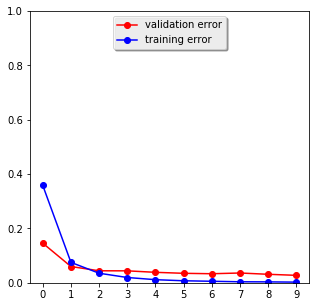

<IPython.core.display.Javascript object>

In [116]:
%%notify -m "18 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.4,EPOCHS=10)

In [117]:
'''
YES Augmentation
YES preprocessing
cnn_mod2
Dropout=0.4
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod2\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.606          0.816
 2                    0.918          0.919
 3                    0.962          0.941
 4                    0.980          0.956
 5                    0.988          0.954
 6                    0.992          0.958
 7                    0.994          0.960
 8                    0.996          0.964
 9                    0.997          0.965
 10                   0.998          0.968
Model saved
Train Accuracy = 0.998
Validation Accuracy = 0.968
Test Accuracy = 0.940


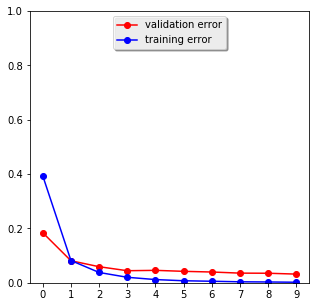

<IPython.core.display.Javascript object>

In [118]:
%%notify -m "18 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.4,EPOCHS=10)

In [119]:
'''
NO Augmentation
NO preprocessing
cnn_mod2
Dropout=0.4
'''

'\nNO Augmentation\nNO preprocessing\ncnn_mod2\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.506          0.723
 2                    0.904          0.875
 3                    0.967          0.907
 4                    0.985          0.924
 5                    0.992          0.932
 6                    0.995          0.937
 7                    0.997          0.931
 8                    0.998          0.931
 9                    0.999          0.938
 10                   0.999          0.949
Model saved
Train Accuracy = 0.999
Validation Accuracy = 0.949
Test Accuracy = 0.924


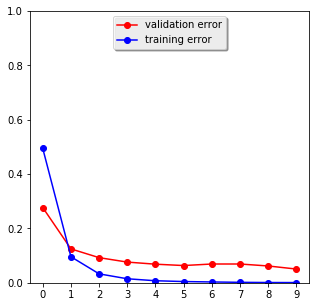

<IPython.core.display.Javascript object>

In [120]:
%%notify -m "19 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.4,EPOCHS=10)

In [121]:
'''
NO Augmentation
NO preprocessing
cnn_mod2
Dropout=0.4
'''

'\nNO Augmentation\nNO preprocessing\ncnn_mod2\nDropout=0.4\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.526          0.717
 2                    0.903          0.866
 3                    0.963          0.903
 4                    0.983          0.917
 5                    0.991          0.922
 6                    0.995          0.937
 7                    0.997          0.938
 8                    0.998          0.939
 9                    0.999          0.939
 10                   0.999          0.943
Model saved
Train Accuracy = 0.999
Validation Accuracy = 0.943
Test Accuracy = 0.928


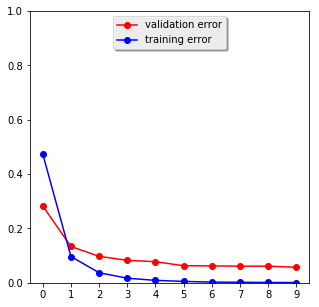

<IPython.core.display.Javascript object>

In [122]:
%%notify -m "19 done"

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.4,EPOCHS=10)

In [15]:
'''
YES Augmentation
YES preprocessing
cnn_mod2
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod2\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.489          0.763
 2                    0.852          0.888
 3                    0.925          0.941
 4                    0.951          0.946
 5                    0.966          0.937
 6                    0.976          0.962
 7                    0.982          0.965
 8                    0.986          0.968
 9                    0.988          0.962
 10                   0.991          0.965
Model saved
Train Accuracy = 0.990
Validation Accuracy = 0.965
Test Accuracy = 0.940


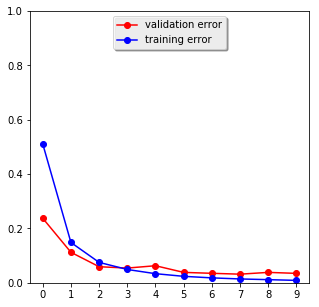

In [18]:
%%notify -m "20 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.2,EPOCHS=10)

In [19]:
'''
YES Augmentation
YES preprocessing
cnn_mod2
Dropout=0.2
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod2\nDropout=0.2\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.471          0.756
 2                    0.863          0.917
 3                    0.937          0.940
 4                    0.961          0.956
 5                    0.974          0.967
 6                    0.981          0.968
 7                    0.986          0.970
 8                    0.989          0.971
 9                    0.991          0.973
 10                   0.993          0.977
Model saved
Train Accuracy = 0.994
Validation Accuracy = 0.977
Test Accuracy = 0.951


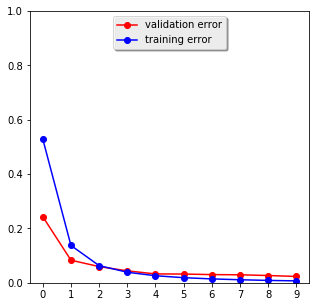

<IPython.core.display.Javascript object>

In [20]:
%%notify -m "20 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.2,EPOCHS=10)

In [21]:
'''
YES Augmentation
YES preprocessing
cnn_mod2
Dropout=0.3
'''

'\nYES Augmentation\nYES preprocessing\ncnn_mod2\nDropout=0.3\n'

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.526          0.780
 2                    0.886          0.923
 3                    0.948          0.949
 4                    0.970          0.951
 5                    0.981          0.965
 6                    0.987          0.963
 7                    0.991          0.968
 8                    0.993          0.970
 9                    0.995          0.969
 10                   0.996          0.967
Model saved
Train Accuracy = 0.996
Validation Accuracy = 0.967
Test Accuracy = 0.947


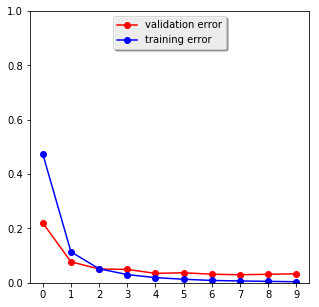

<IPython.core.display.Javascript object>

In [22]:
%%notify -m "21 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.3,EPOCHS=10)

In [117]:
#Lets test out the 3 models against my examples.

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.521          0.807
 2                    0.877          0.938
 3                    0.943          0.959
 4                    0.963          0.970
 5                    0.975          0.974
 6                    0.982          0.979
 7                    0.986          0.972
 8                    0.989          0.978
 9                    0.991          0.969
 10                   0.993          0.974
Model saved
Train Accuracy = 0.991
Validation Accuracy = 0.974
Test Accuracy = 0.950


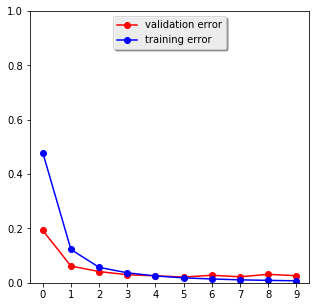

<IPython.core.display.Javascript object>

In [118]:
%%notify -m "13 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn,dropout_rate=0.2,EPOCHS=10)

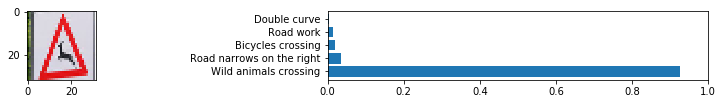

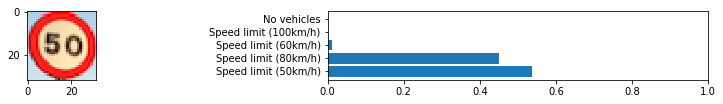

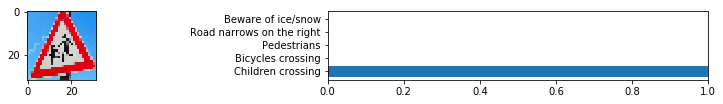

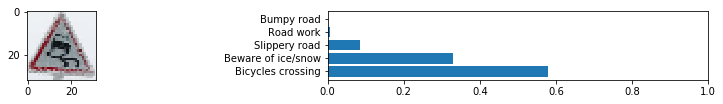

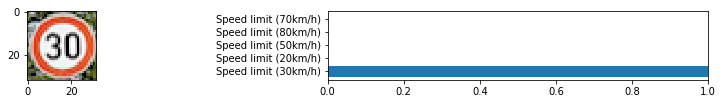

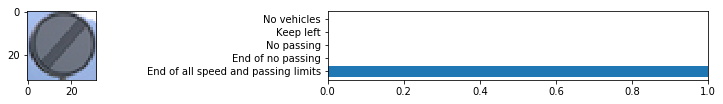

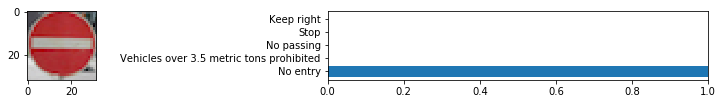

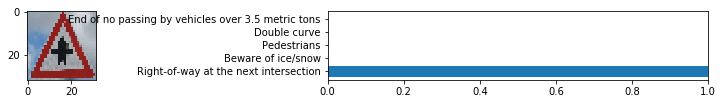

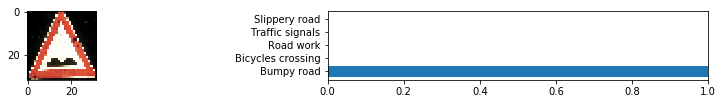

In [119]:
a=myexamples('hist')

(9, 32, 32, 1)


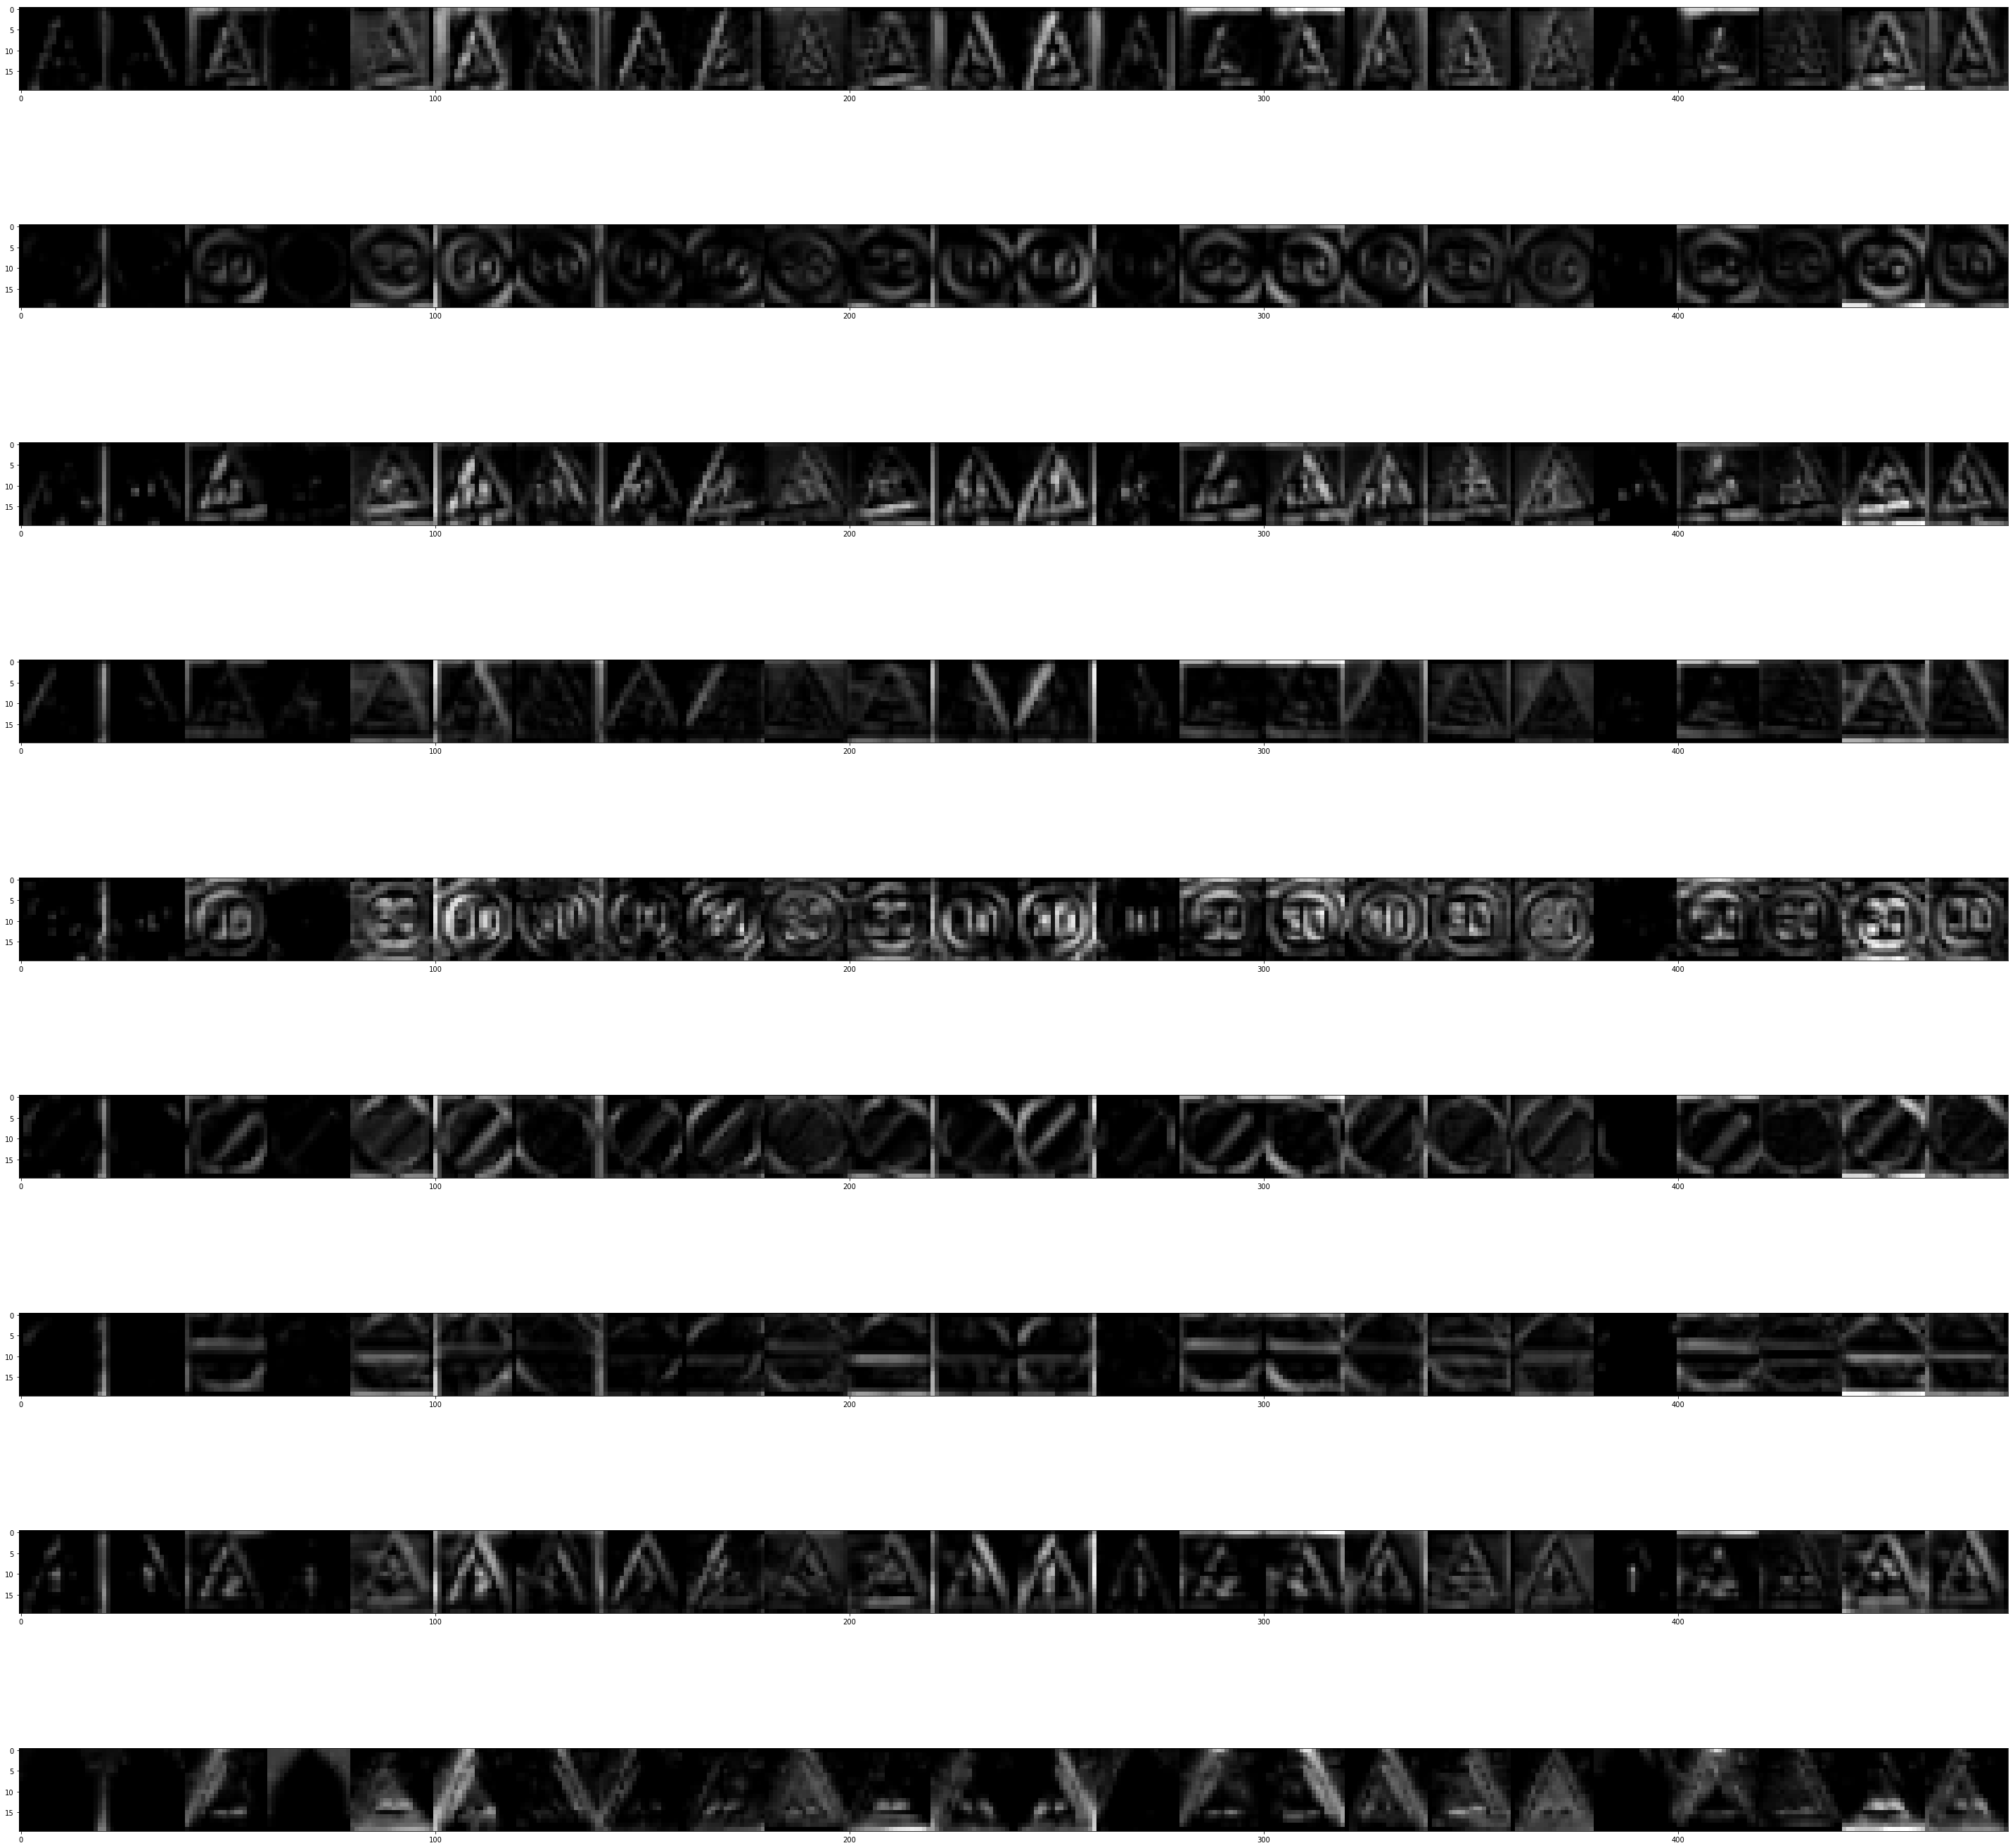

In [120]:
print(a.shape)
showfeature(a,conv_layer1)

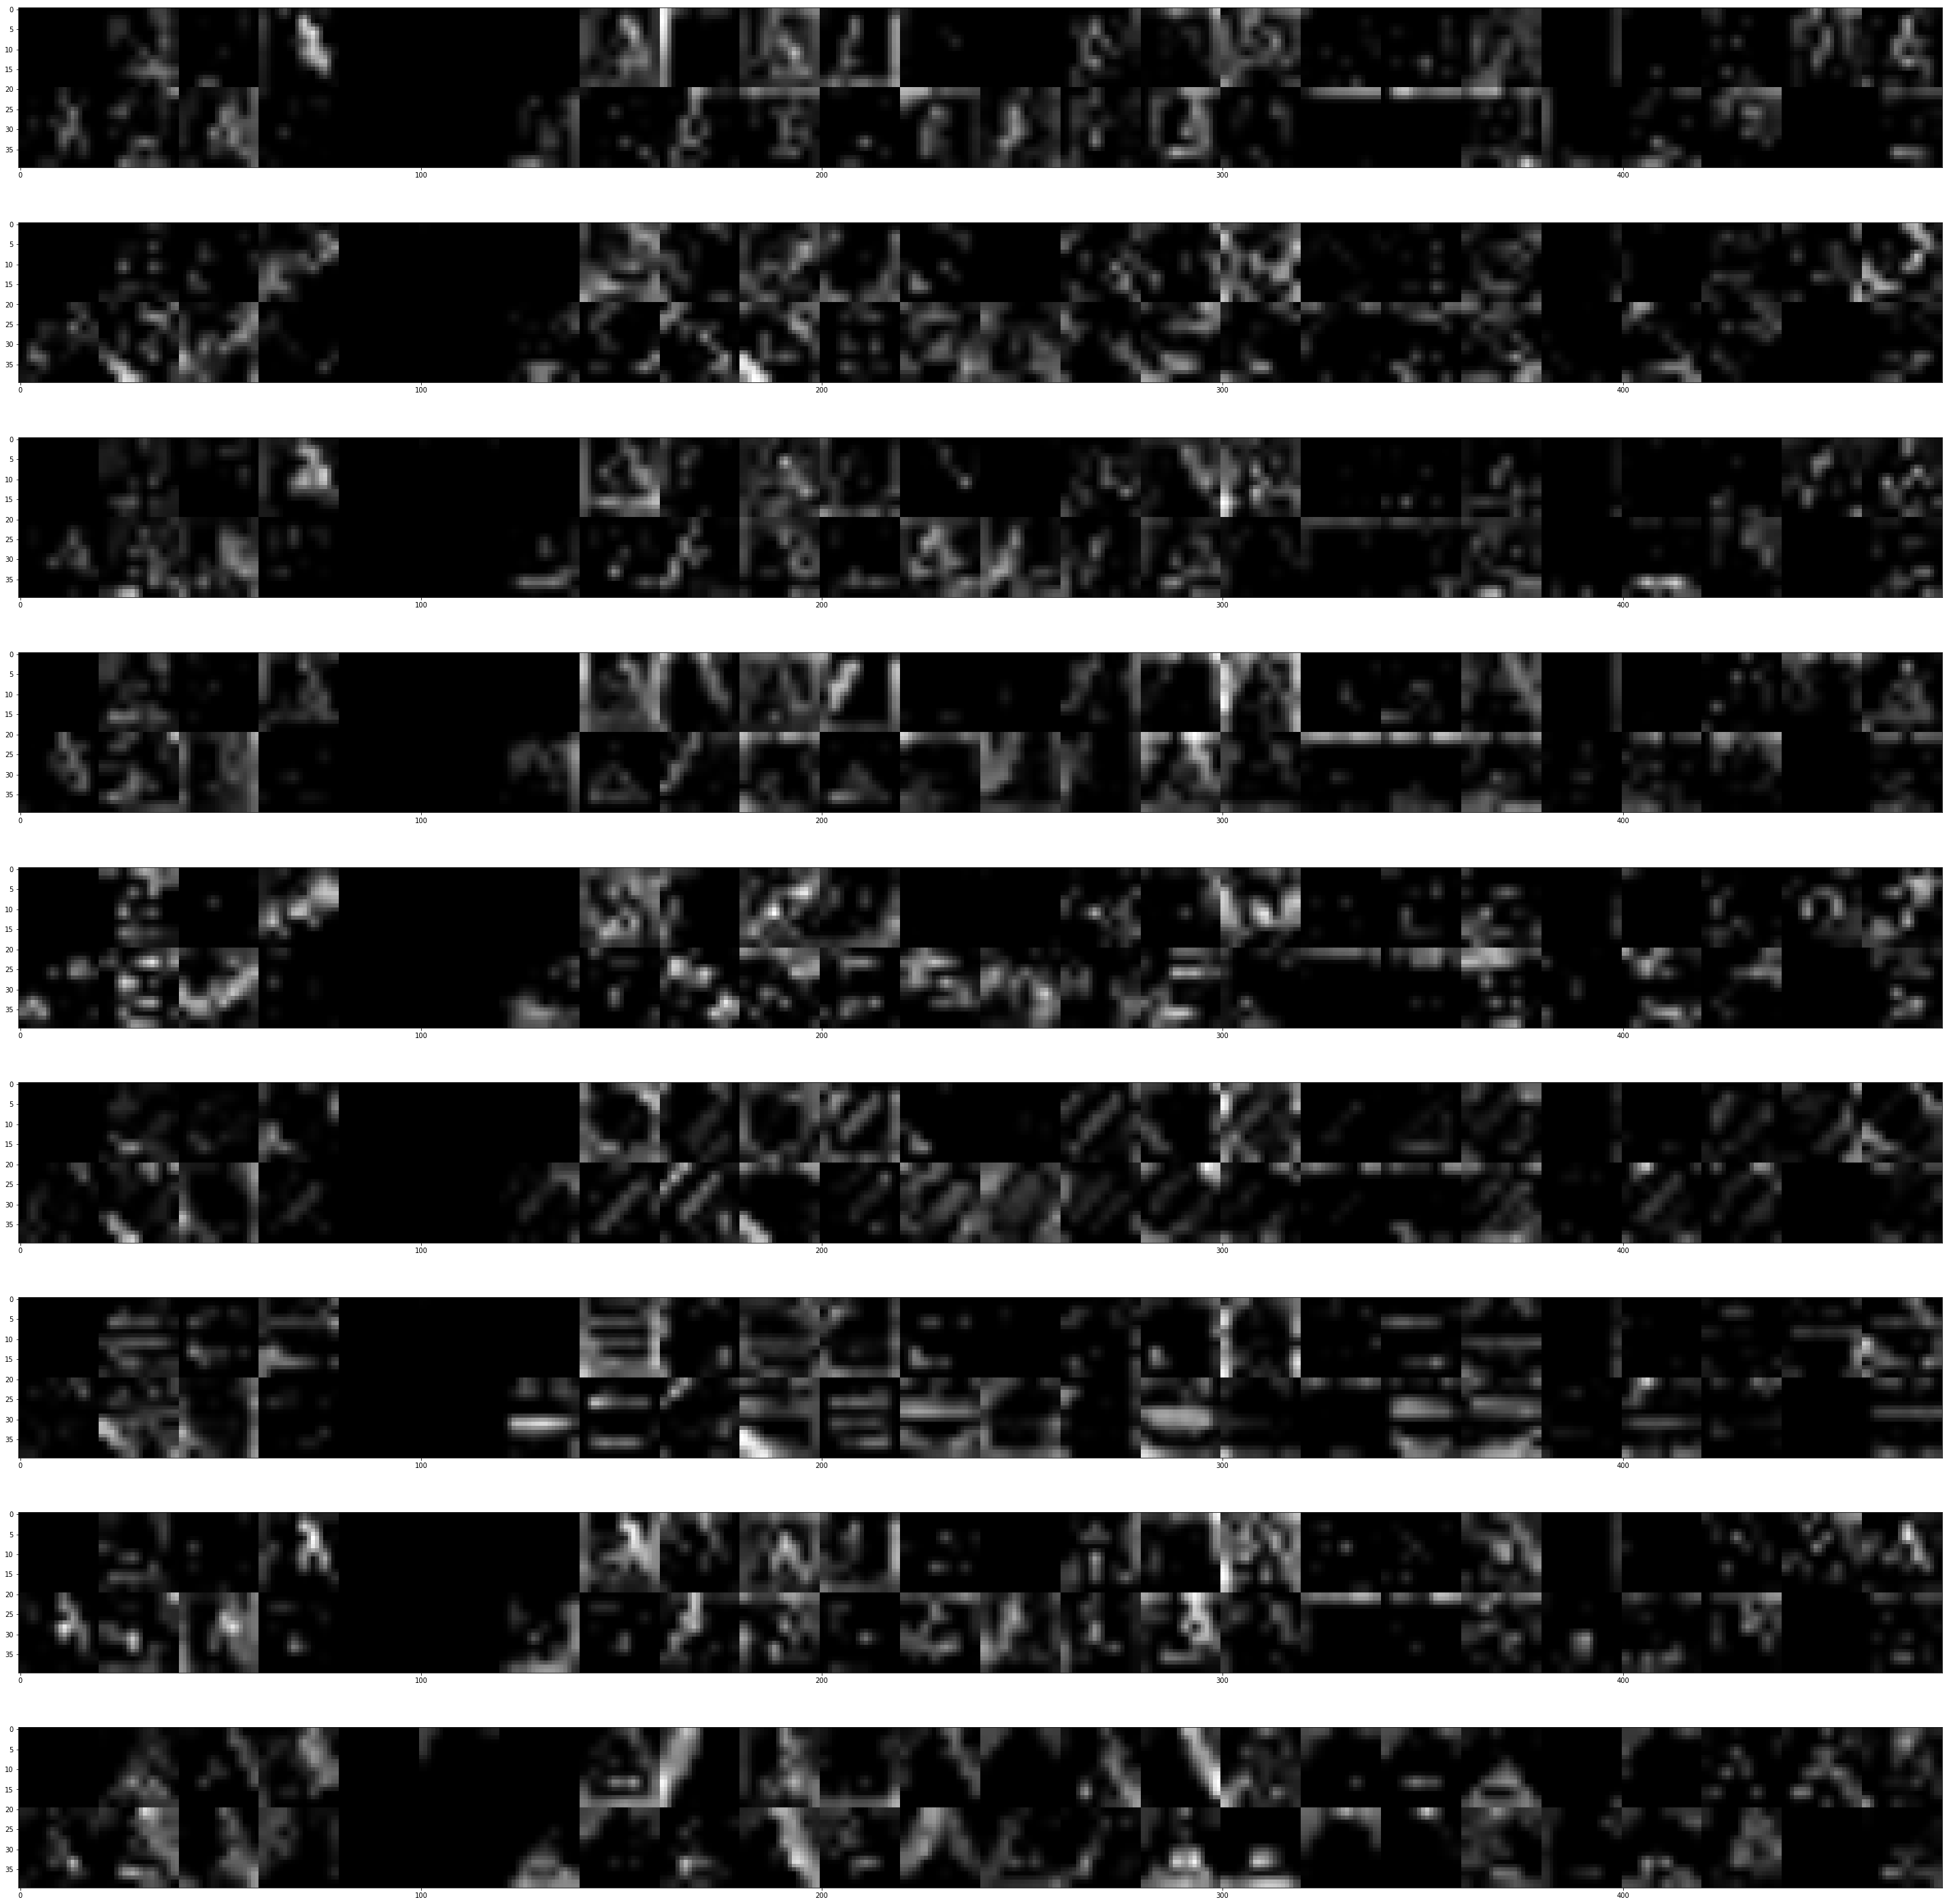

In [121]:
showfeature(a,conv_layer2)

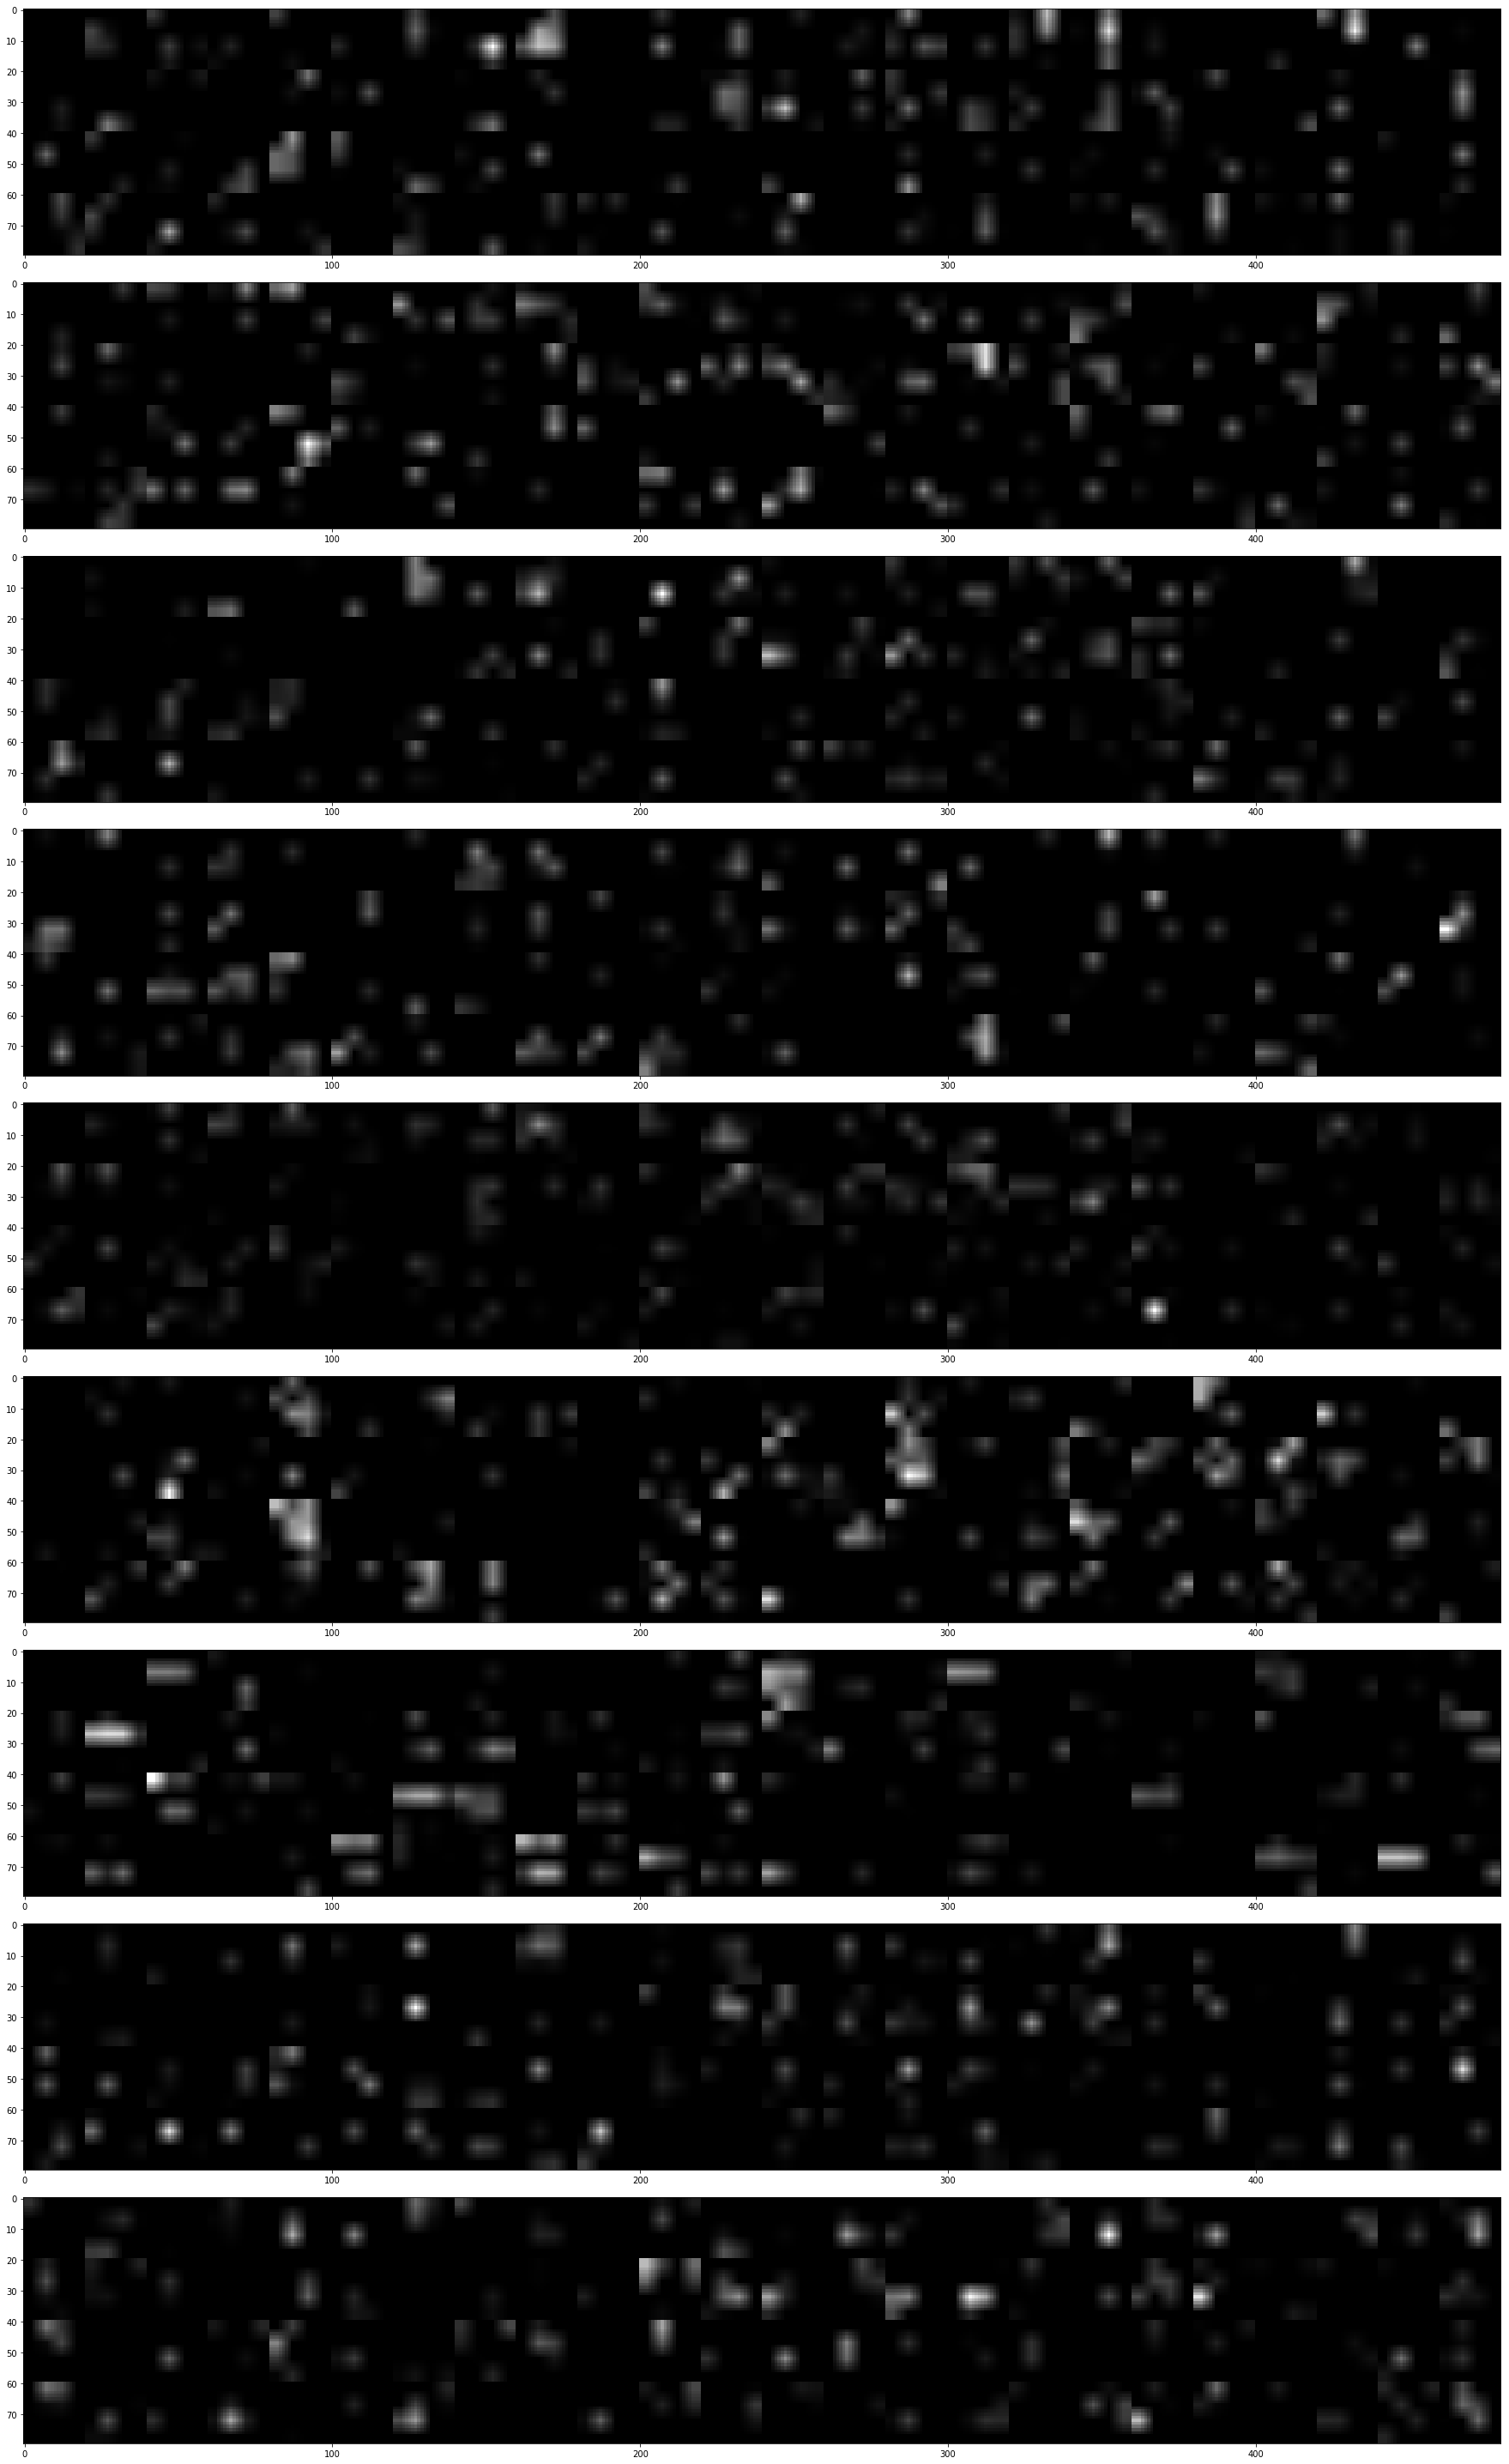

In [122]:
showfeature(a,conv_layer3)

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.486          0.749
 2                    0.858          0.914
 3                    0.935          0.945
 4                    0.961          0.956
 5                    0.975          0.964
 6                    0.981          0.966
 7                    0.986          0.971
 8                    0.989          0.970
 9                    0.991          0.972
 10                   0.993          0.968
Model saved
Train Accuracy = 0.993
Validation Accuracy = 0.968
Test Accuracy = 0.948


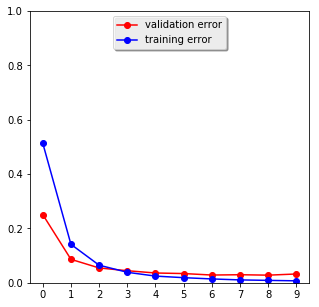

<IPython.core.display.Javascript object>

In [138]:
%%notify -m "15 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod,dropout_rate=0.2,EPOCHS=10)

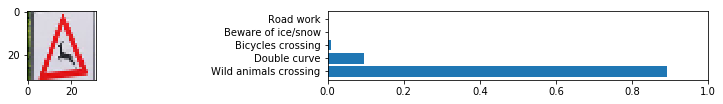

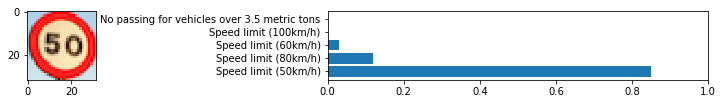

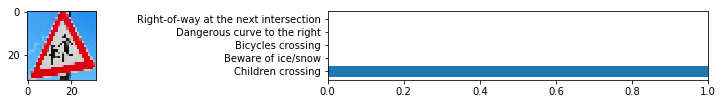

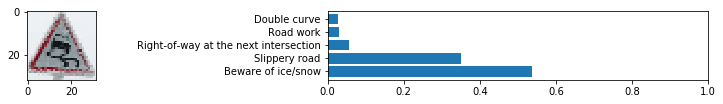

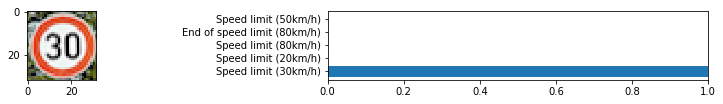

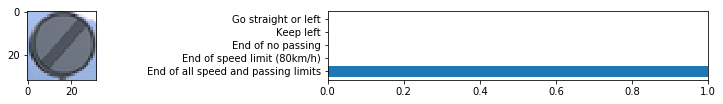

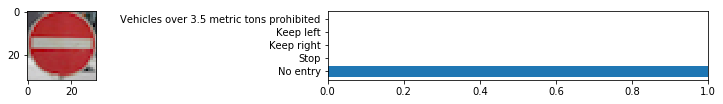

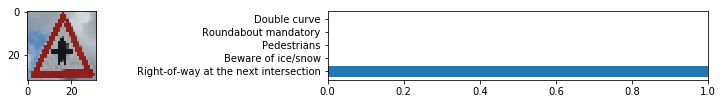

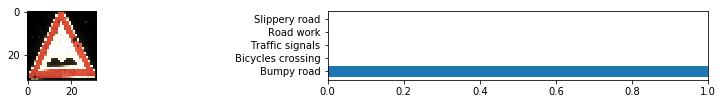

In [139]:
a=myexamples('hist')

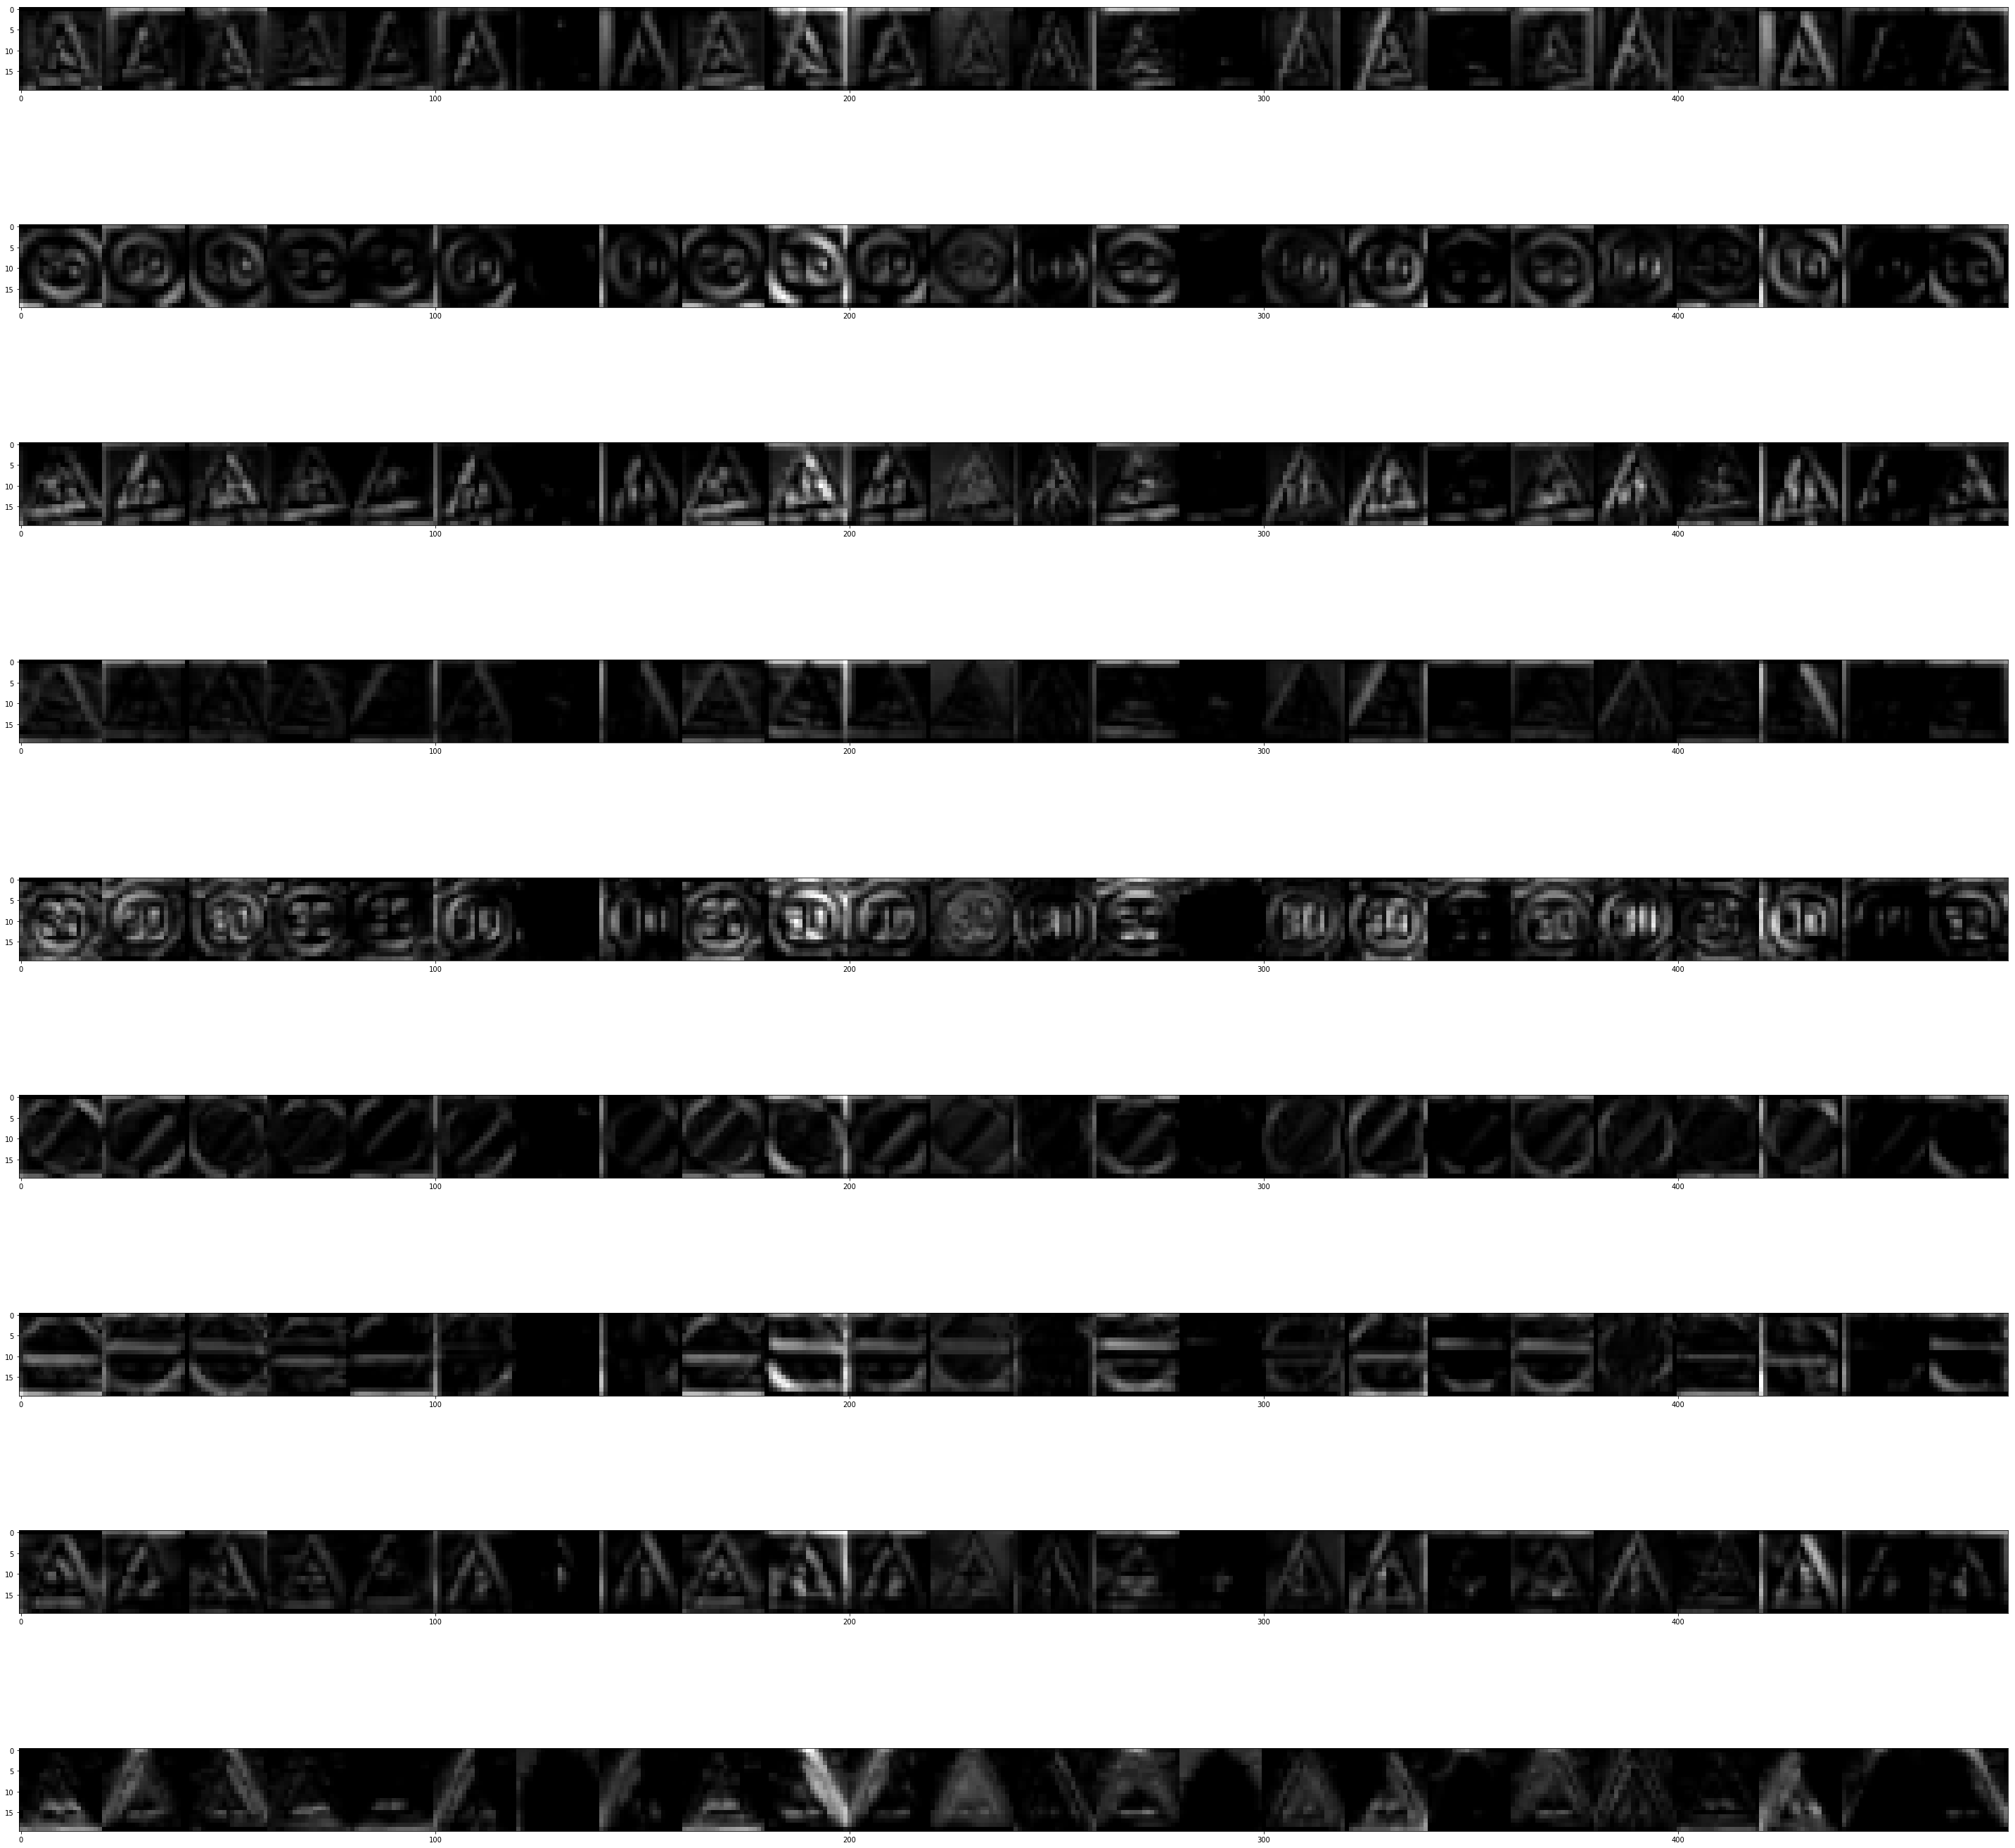

In [140]:
showfeature(a,conv_layer1)

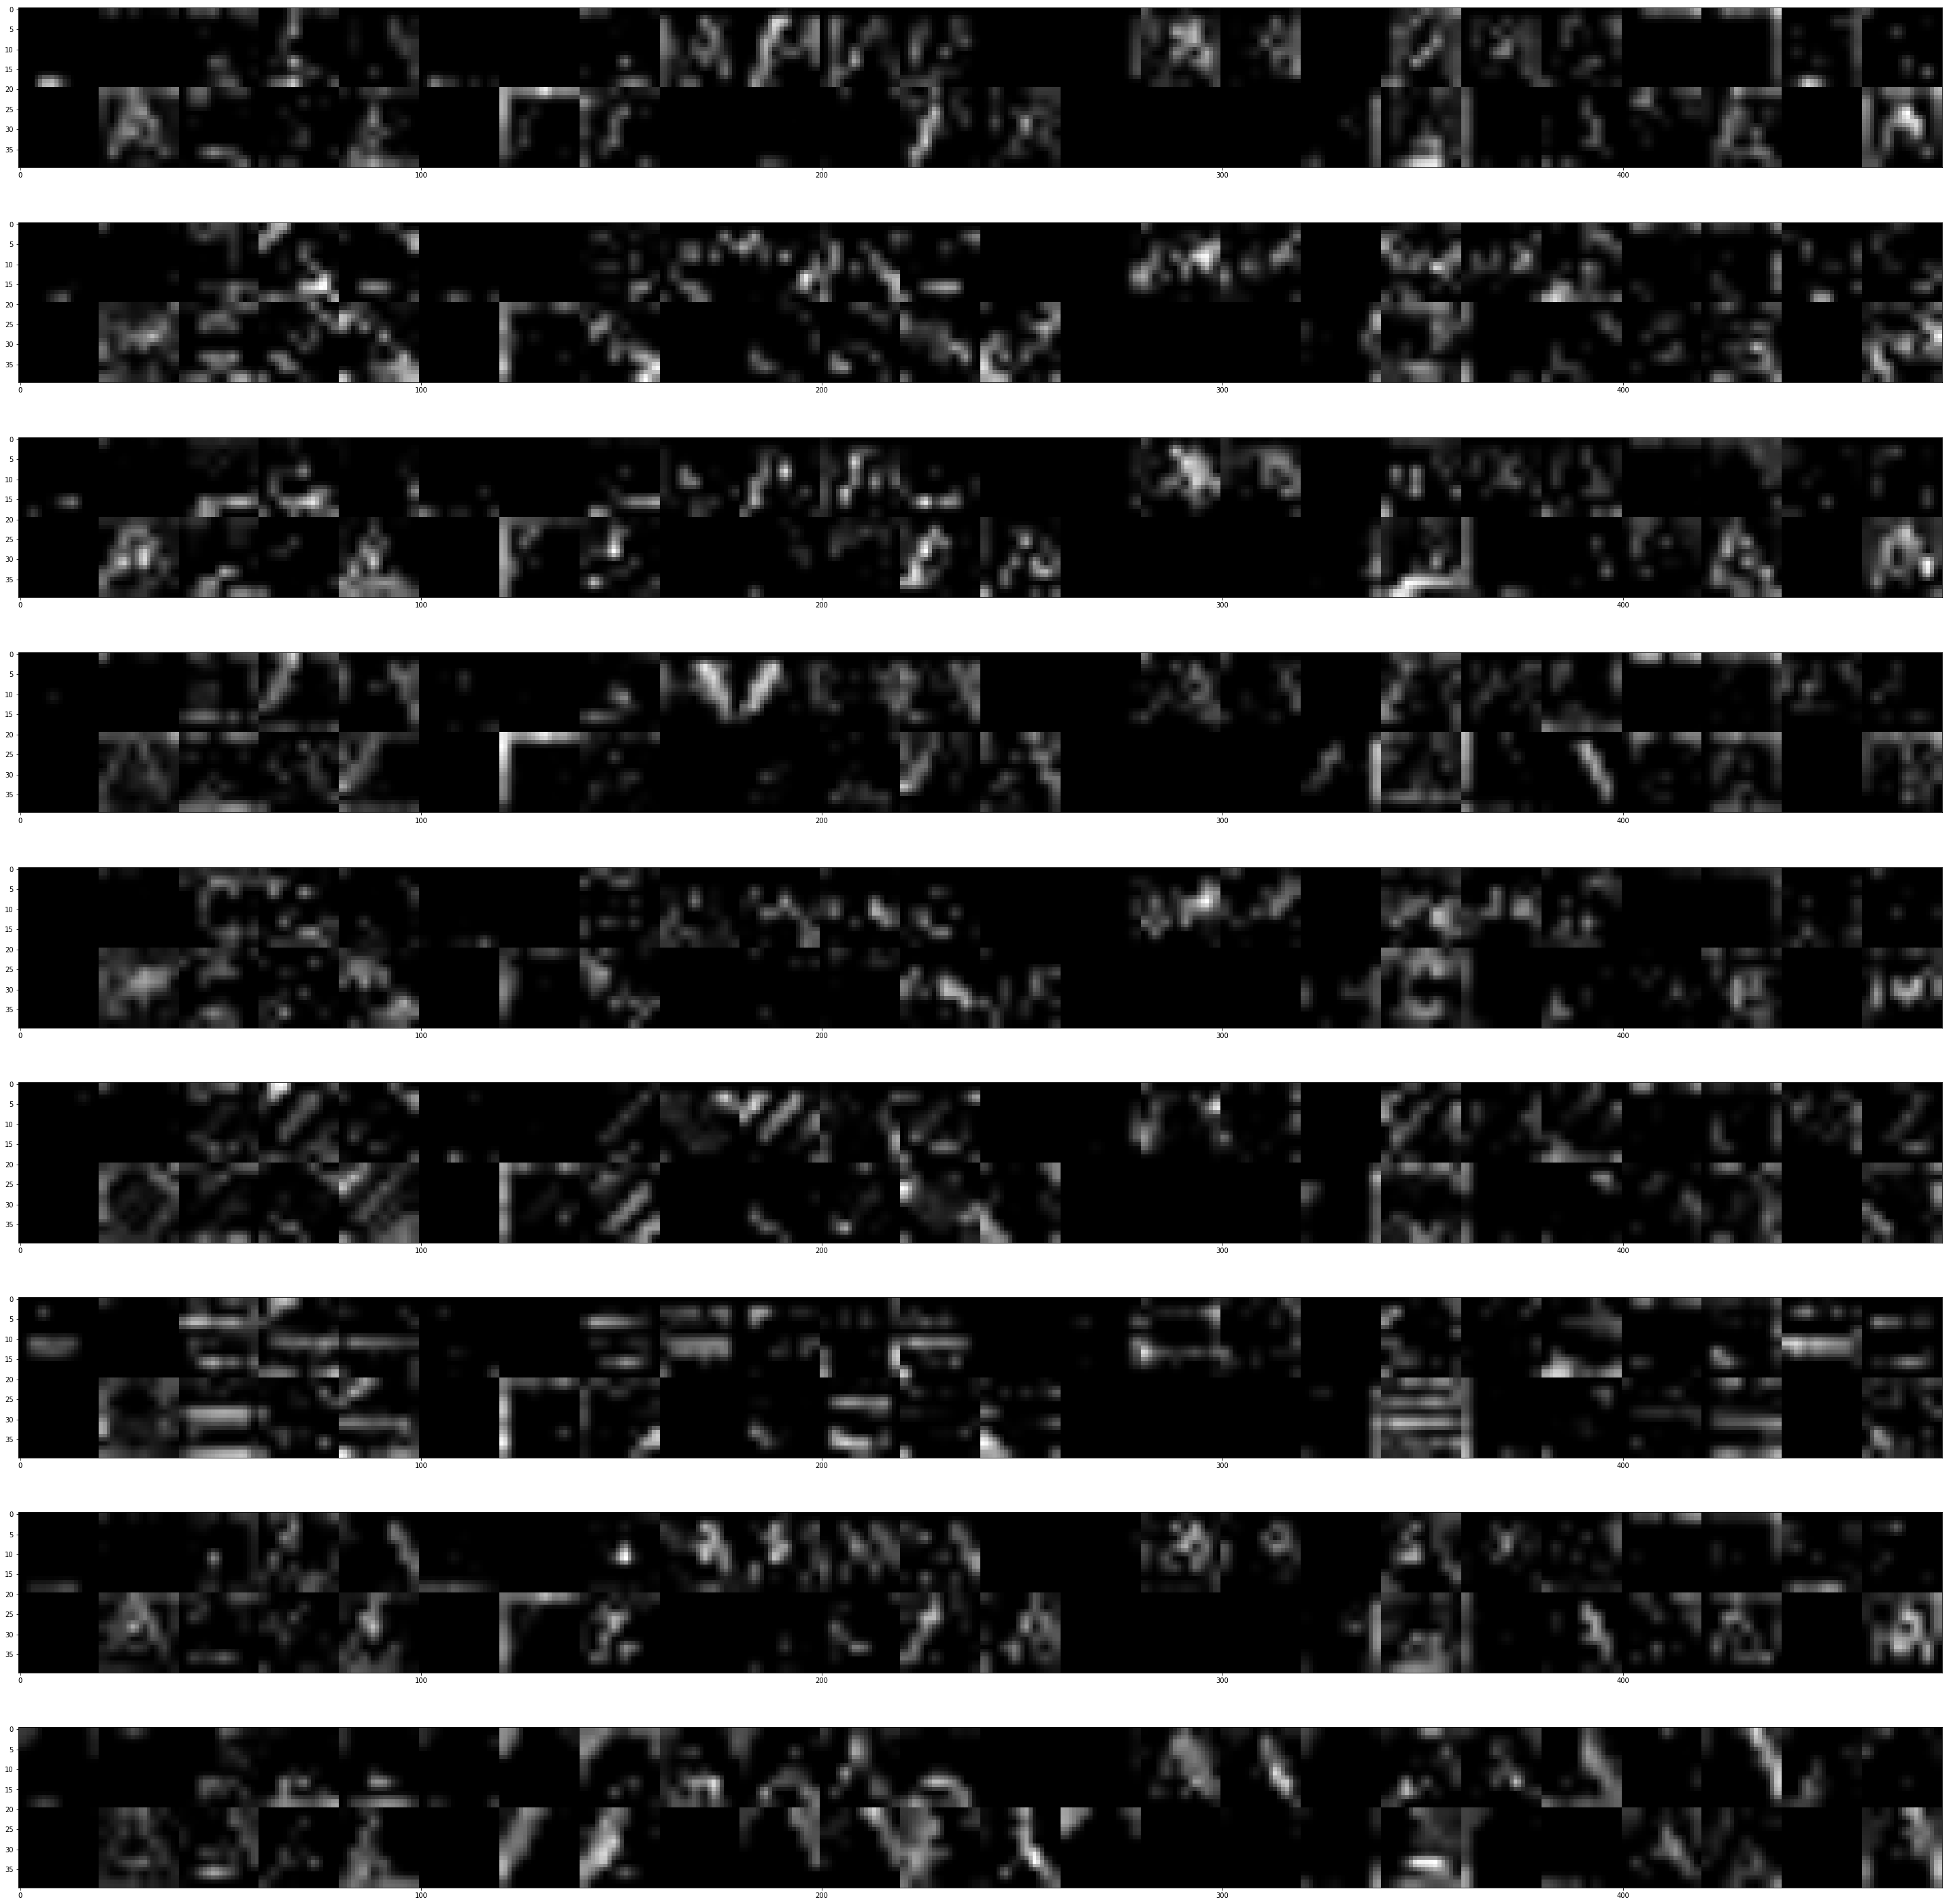

In [141]:
showfeature(a,conv_layer2)

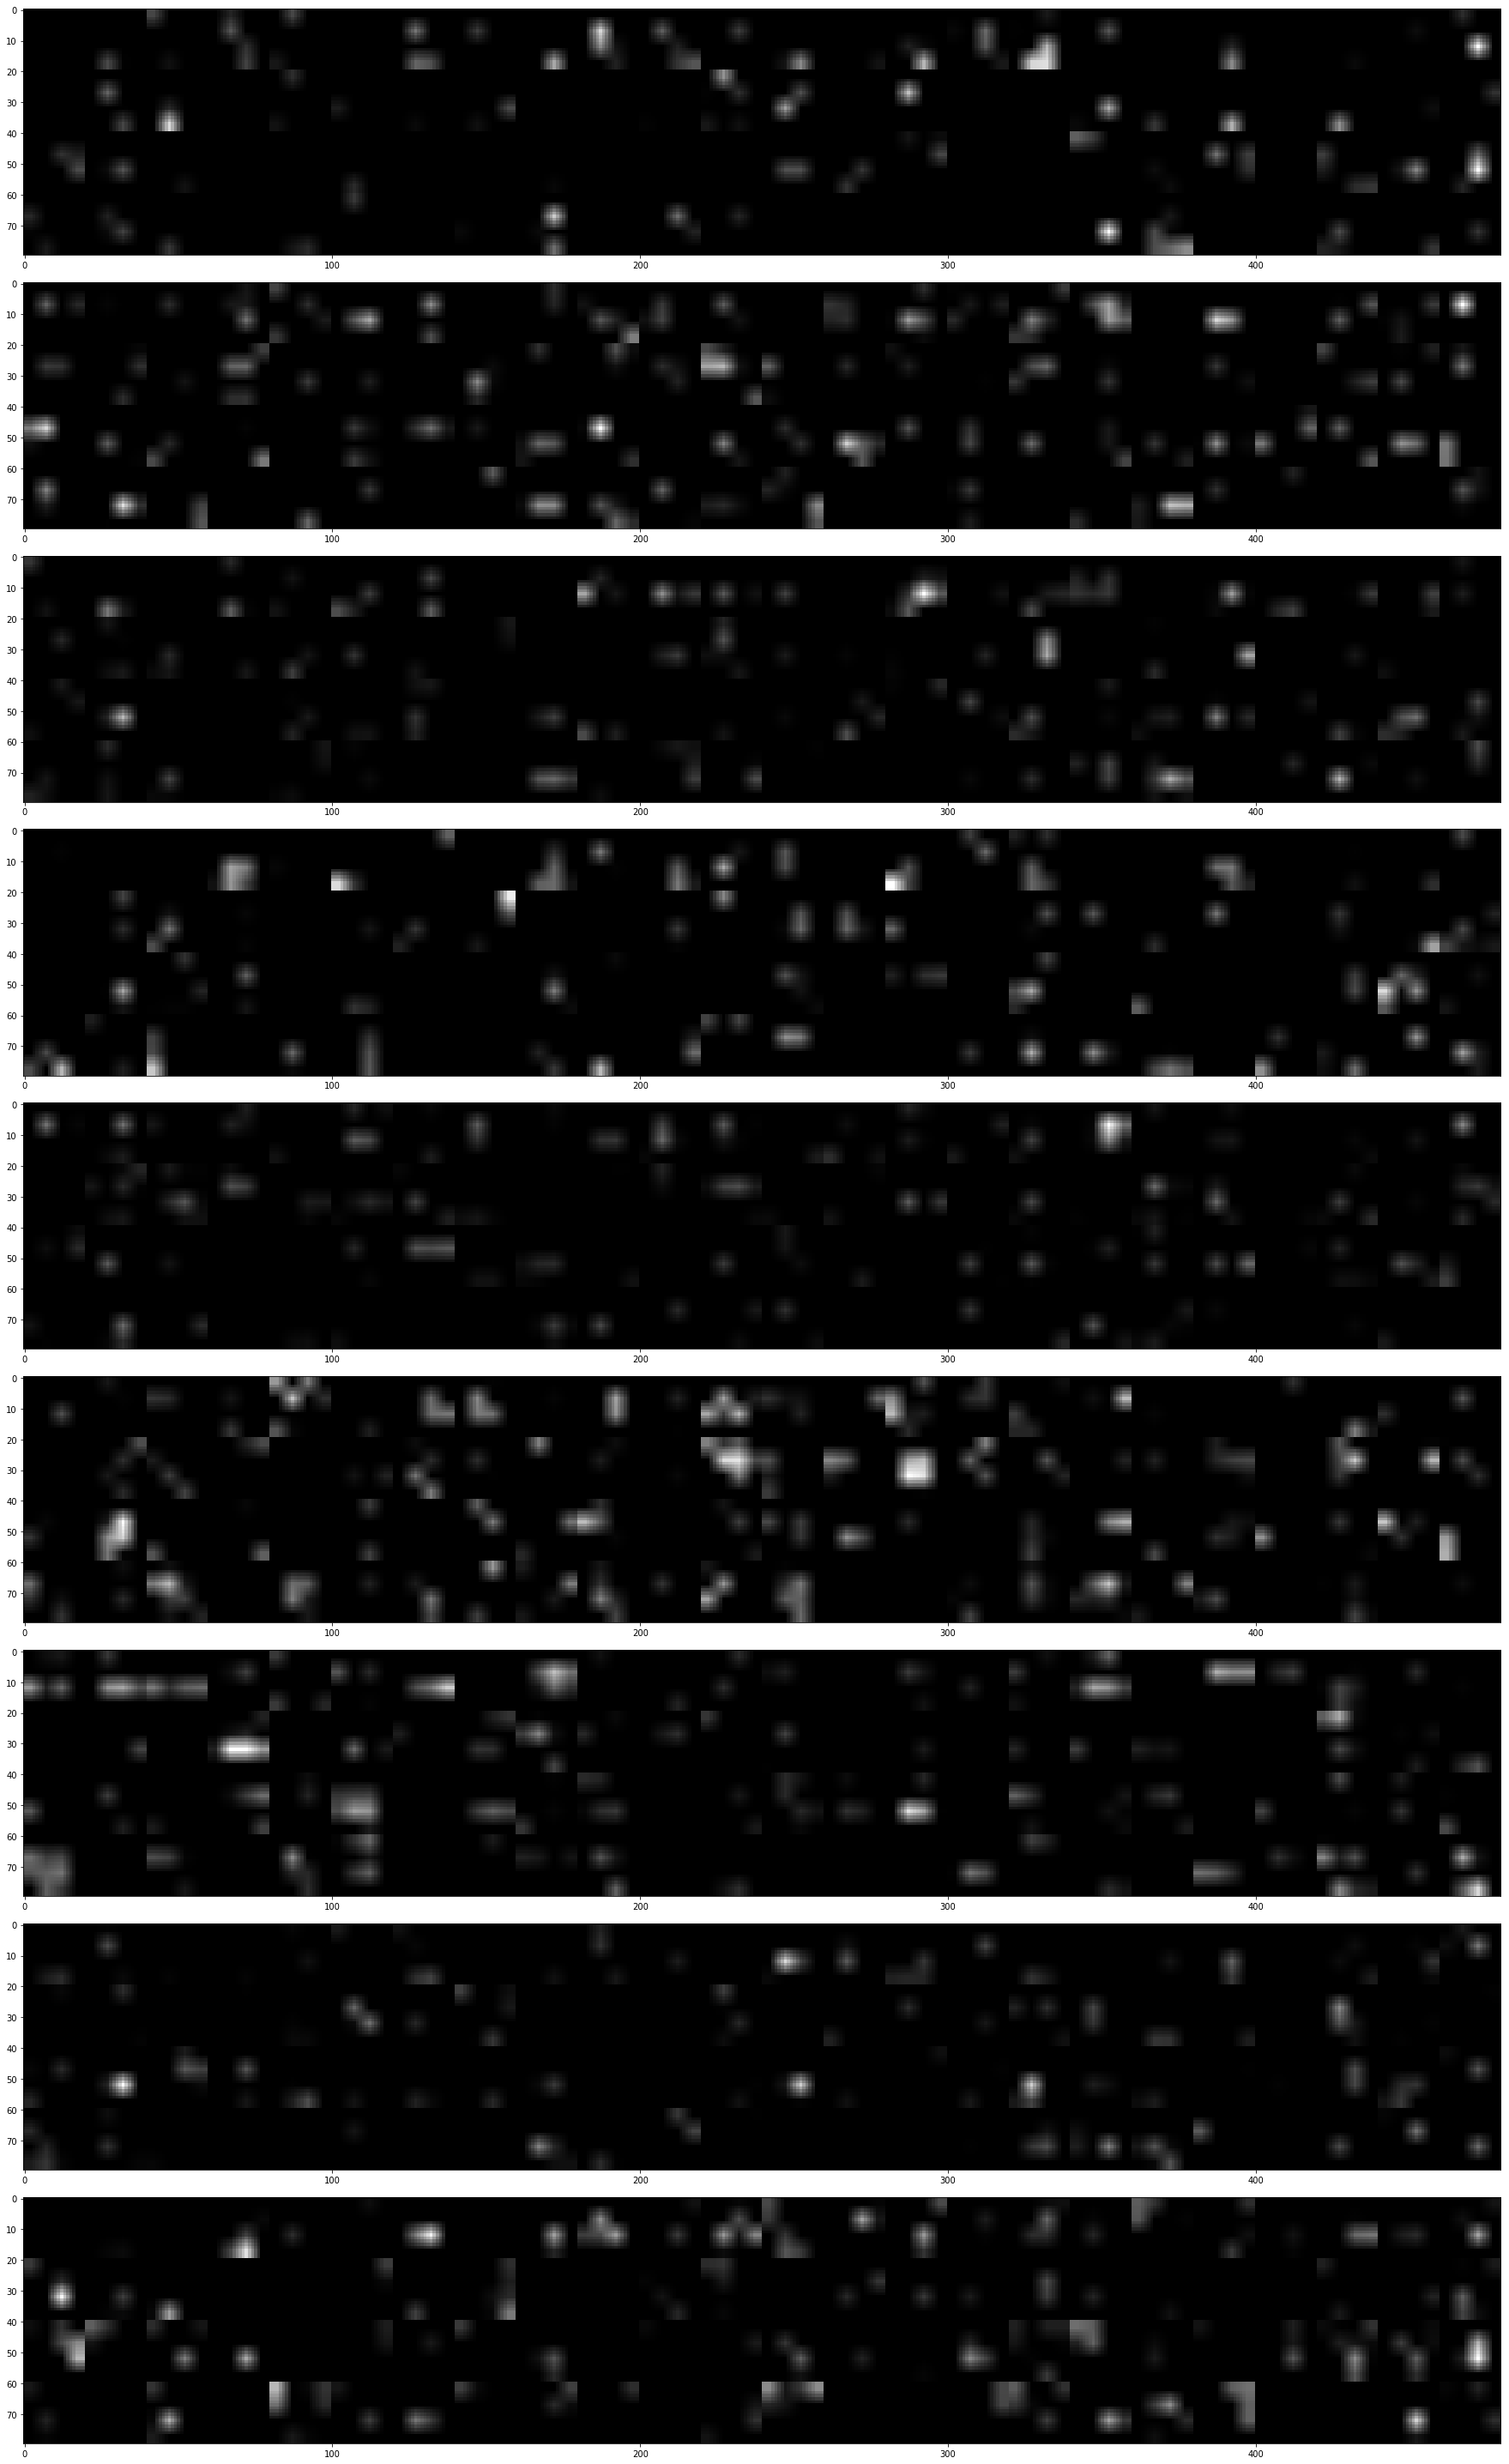

In [142]:
showfeature(a,conv_layer3)

Training...

EPOCH     Train Accuracy Validation Accuracy
 1                    0.477          0.763
 2                    0.855          0.915
 3                    0.933          0.949
 4                    0.962          0.962
 5                    0.974          0.969
 6                    0.981          0.970
 7                    0.985          0.975
 8                    0.989          0.978
 9                    0.991          0.975
 10                   0.993          0.982
Model saved
Train Accuracy = 0.995
Validation Accuracy = 0.982
Test Accuracy = 0.954


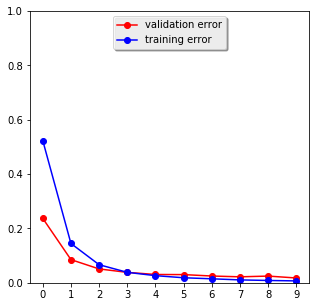

<IPython.core.display.Javascript object>

In [128]:
%%notify -m "20 done"

X_train=X_train_aug.copy()
y_train=y_train_aug.copy()
X_validation=X_validation_orig.copy()
y_validation=y_validation_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()
preprocess_flag='hist'

X_train=pipeline(X_train,preprocess_flag)
X_validation=pipeline(X_validation,preprocess_flag)
X_test=pipeline(X_test,preprocess_flag)

train(function=cnn_mod2,dropout_rate=0.2,EPOCHS=10)

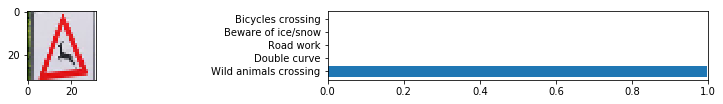

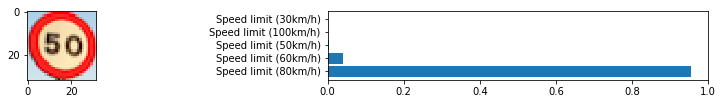

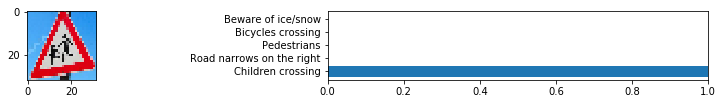

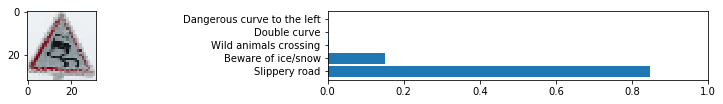

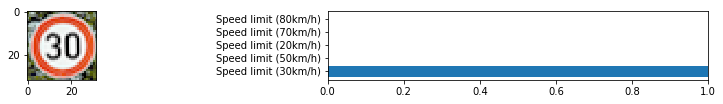

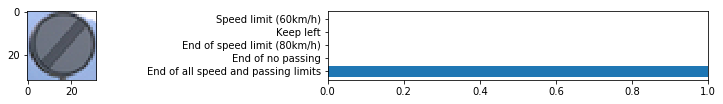

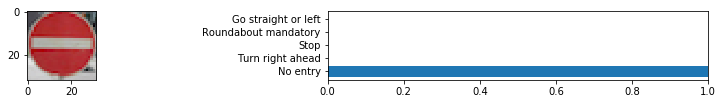

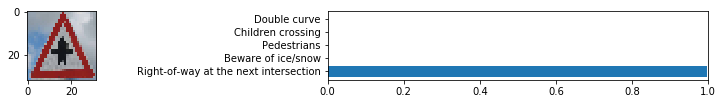

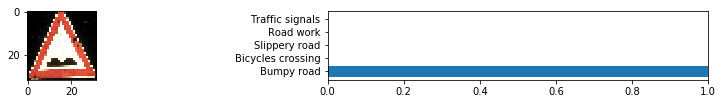

In [129]:
a=myexamples('hist')

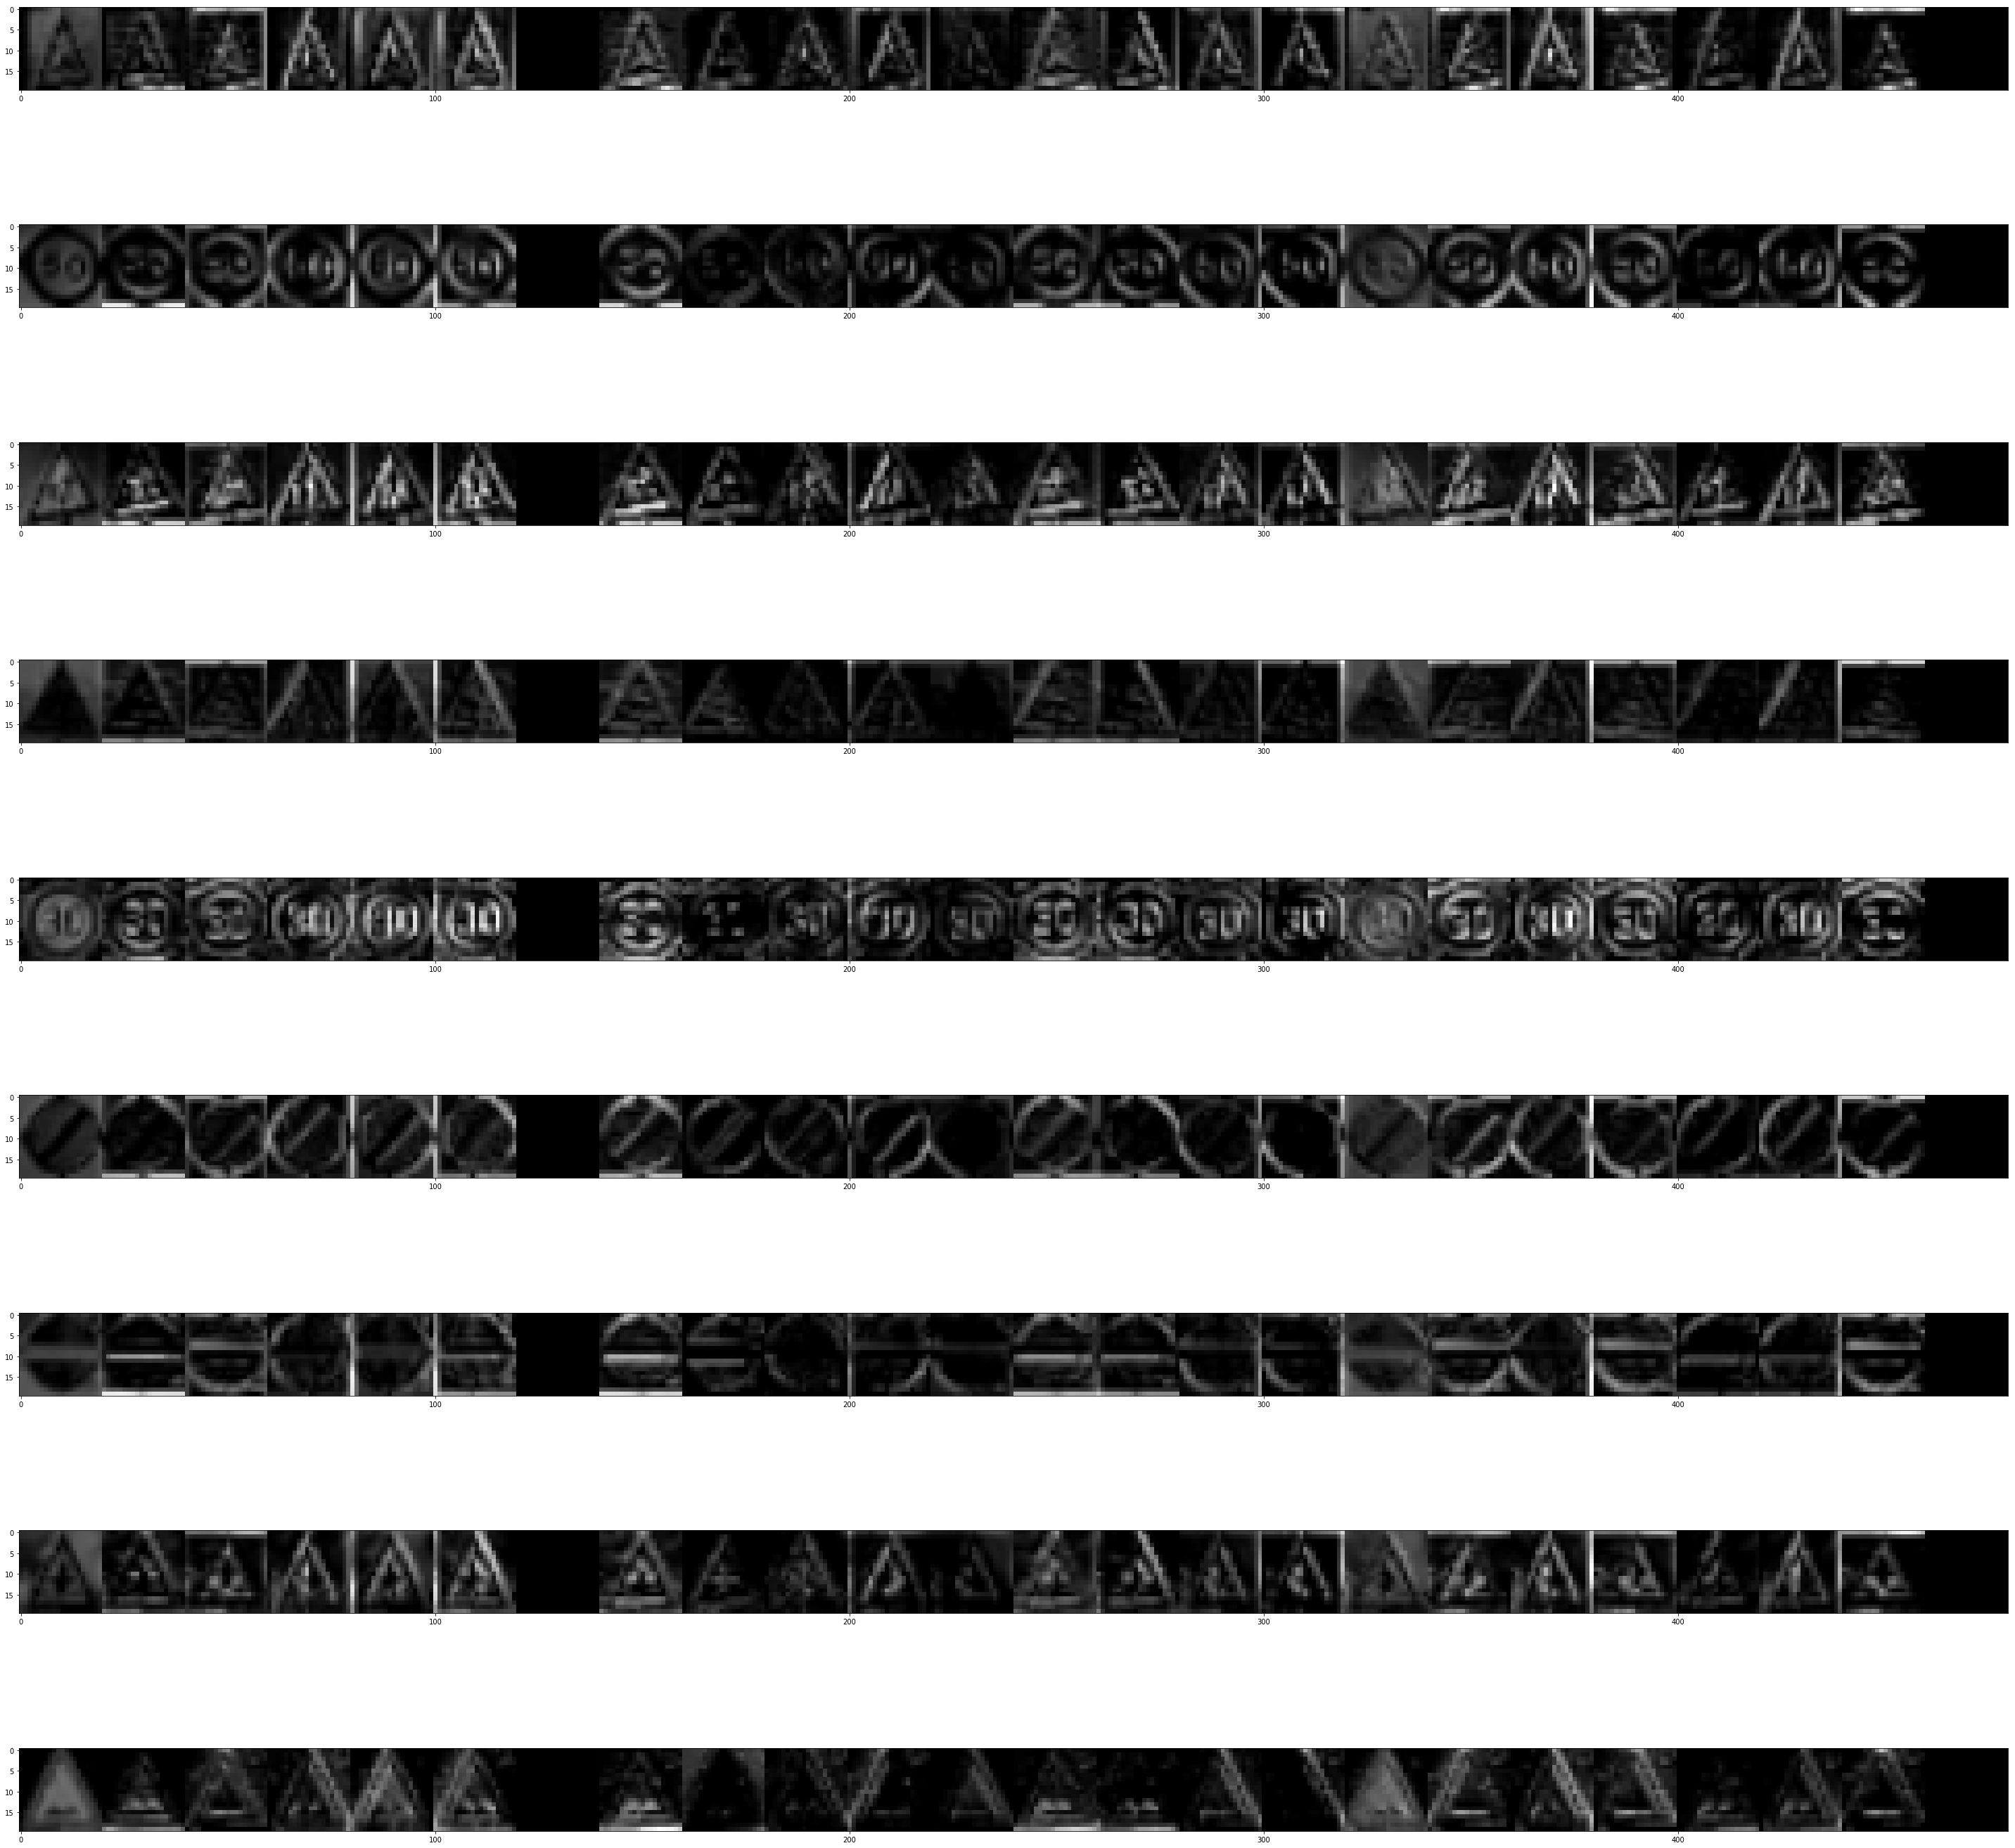

In [130]:
showfeature(a,conv_layer1)

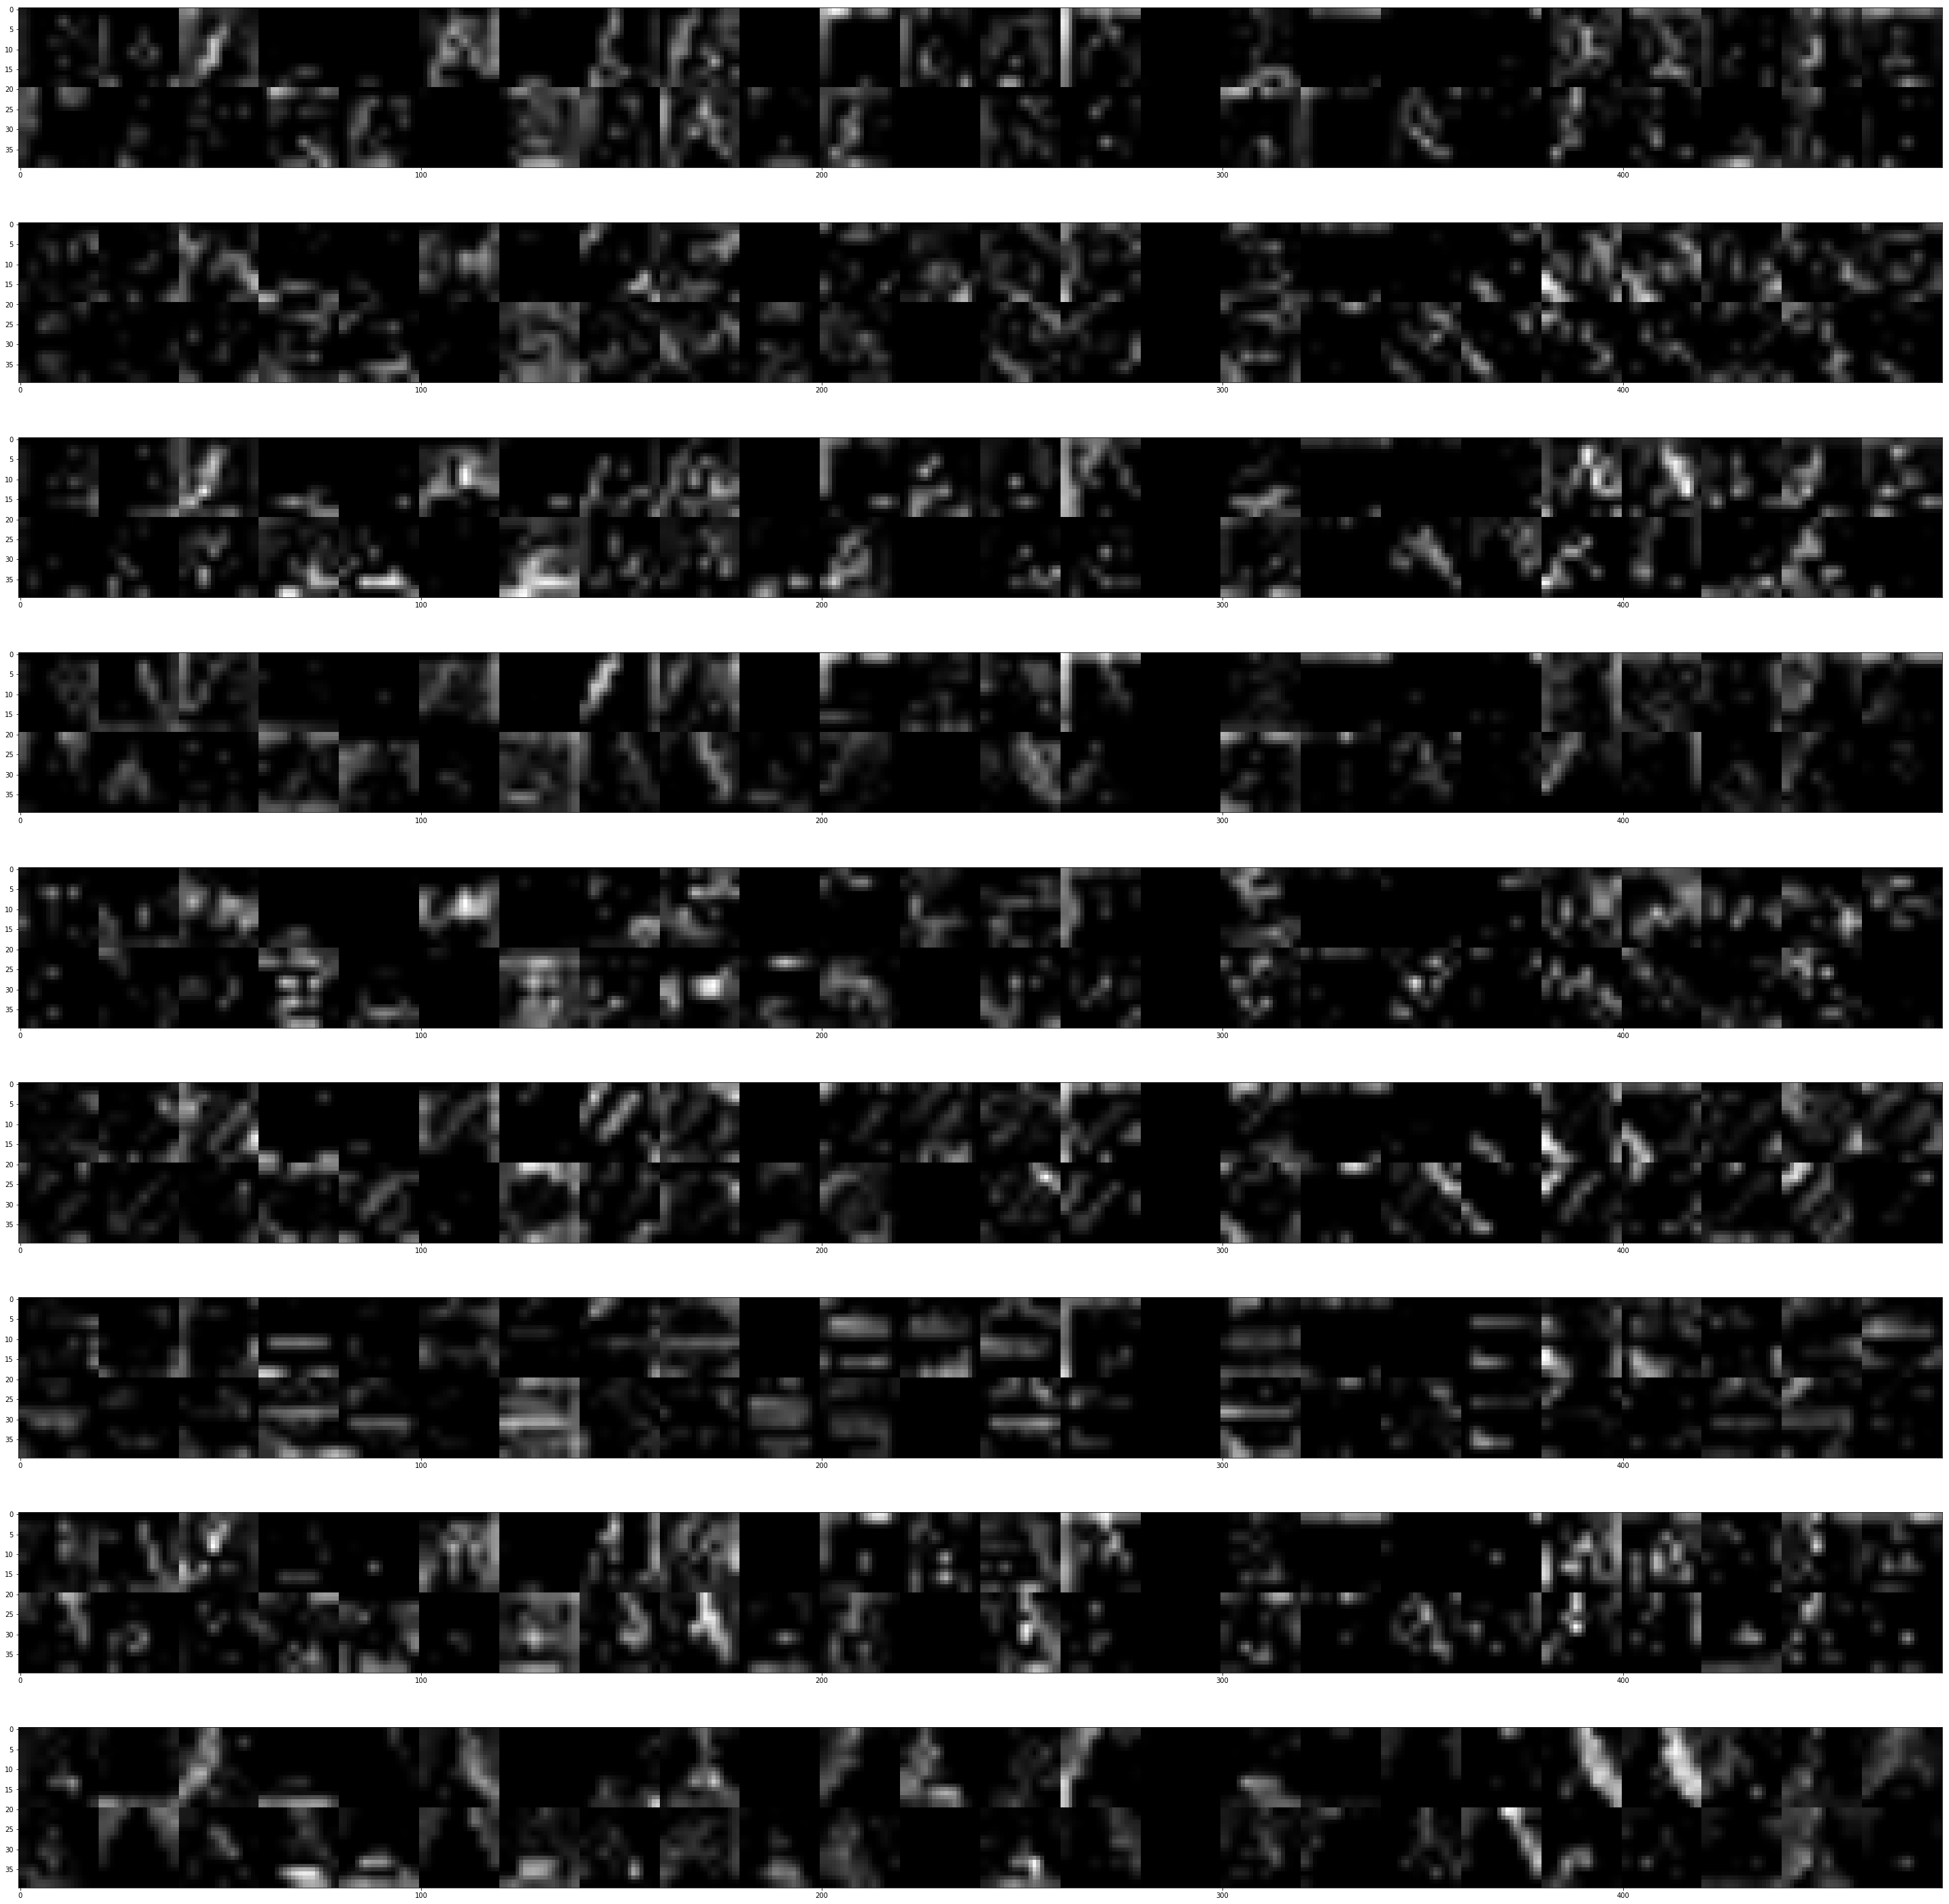

In [131]:
showfeature(a,conv_layer2)

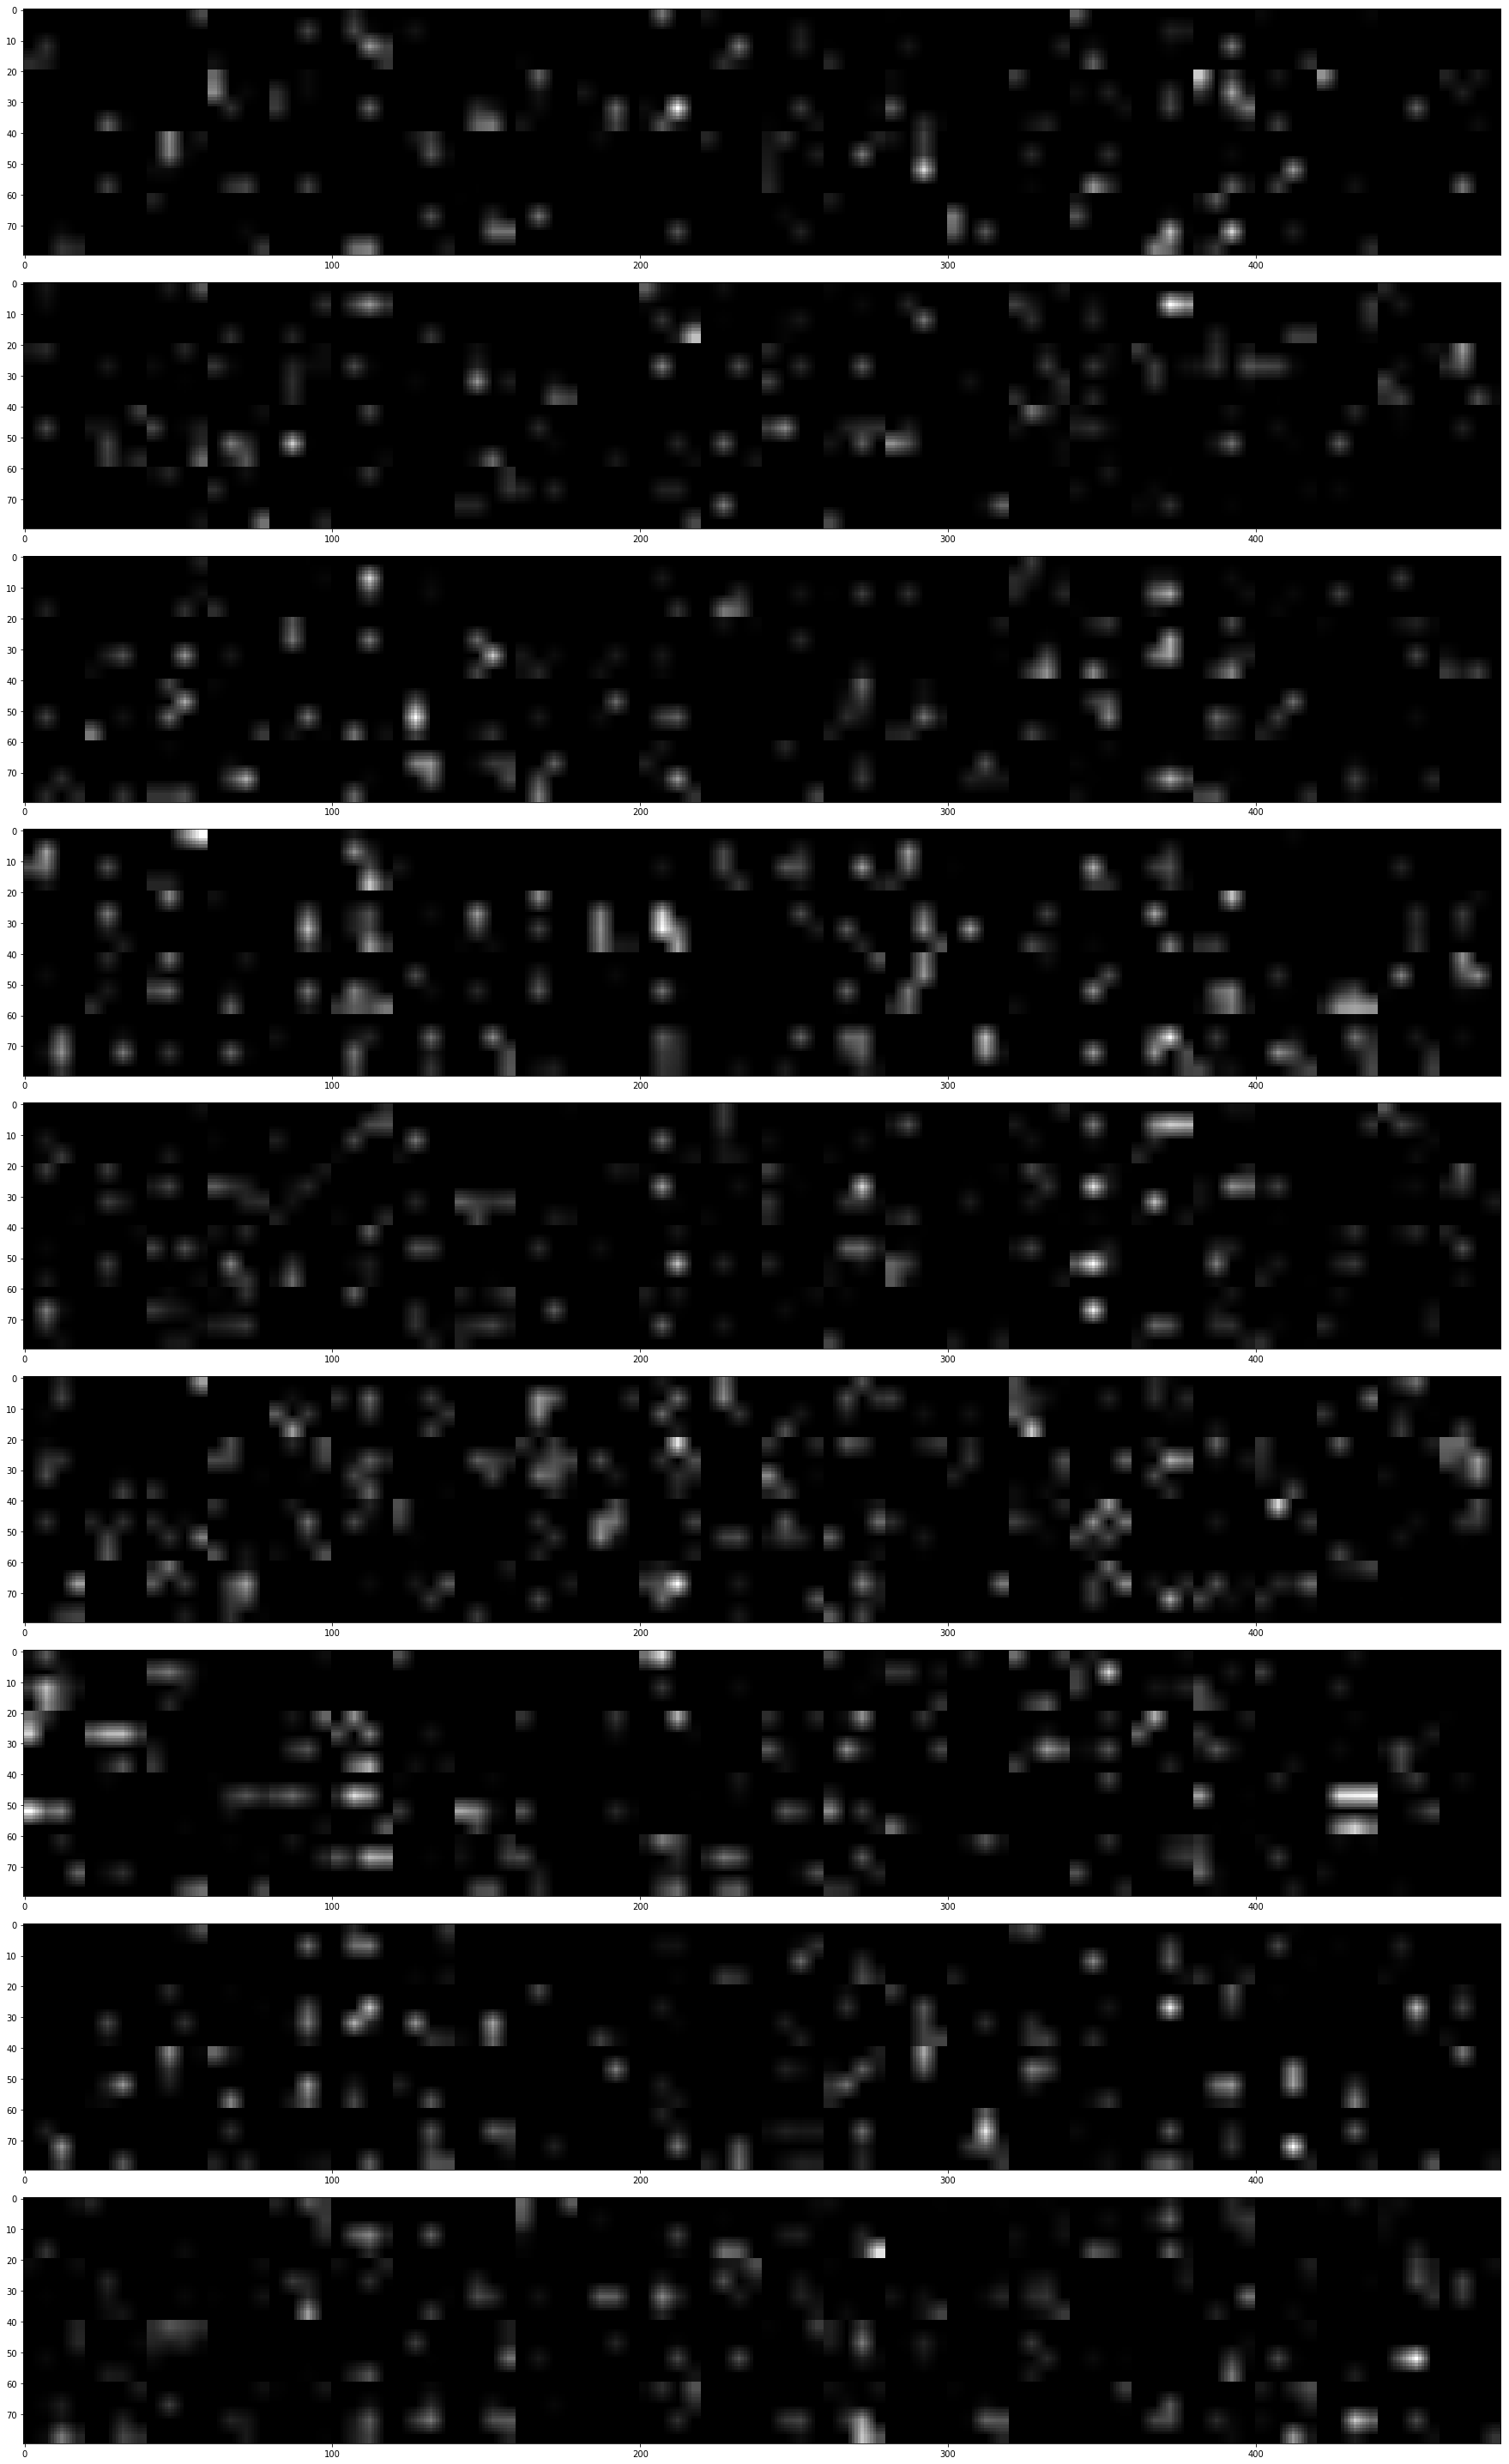

In [132]:
showfeature(a,conv_layer3)